# Explainer notebook
Final project in 02806 Social data analysis and visualization at DTU, Spring 2020.

Website: https://nyc-public-schools.github.io/

Github: https://github.com/nyc-public-schools/nyc-public-schools.github.io/

Note: The folium and bokeh plots might not be visible, wherefore static images have been inserted instead. Please refer to the website and github for interactivity.

## 1. Motivation

### 1.1 Purpose
*What was your goal for the end user's experience?*

Our idea with this project was to investigate the schools of New York city through data analysis and visualization. The findings are presented as a narrative data story. The goal was to provide an overview of the schools and thereby help new citizens of New York to choose a school based on their preferences. To do this we made a choropleth map where the user can choose a variable and explore differences in the school districts and boroughs in relation to this variable. The user should also be able to explore specific schools and see the historic development of selected variables. Ultimately, we created an interactive application where the user can enter preferences and receive an overview of the matching schools. In this way, the user should be able to find his or her "dream school". 

### 1.2 Datasets
*What is your dataset and why did you choose these particular datasets?*

To find relevant data about the schools of NYC, we used open data published by NYC agencies and other partners from the website https://data.cityofnewyork.us. Since this data source only provides data for the public schools, these were chosen as our focus. 

For the purposes discribed above, not only the most recent data for each school was needed, but also temporal data for a range of years. The data source provided datasets containing data on public middle and high schools from 2006 to 2018, which was very convenient for showing the development for each school. However, we also found datasets from 2018, which contained much more information about each school. Hence, we created a dynamic dataset with some information from 2006 to 2018 and a static dataset with more information from 2018, for both the middle and high schools.

Both the middle and high school datasets included spatial data such as the borough, district, address, latitude and longitude of the specific schools. However, the datasets for the middle schools were larger and contained more attributes relevant for measuring school performance, such as math scores and english language art (ELA) scores. As a result, we narrowed our focus down to middle schools only, thereby halving the number of datasets. Accordingly, it was relevant to only include the data processing and analysis of the middle school data in this notebook.

Furthermore, we also found relevant data attributes from other datasets that we wanted to include. These were school related attributtes such as attendance, class sizes and quality ratings, which were merged onto the raw datasets using the unique school ID, DBN. Additionally, we found interesting demographic attributes describing the districts and boroughs, such as rent prices and crime rates. These were merged onto the datasets using the location (latitude, longitude, postal code) of the schools.  

To sum up, the following 20 csv and xlsx files were used in the project:

- 2018_DOE_Middle_School_Directory.csv

- 2006_-_2012__Math_Test_Results__-_All_Students.csv

- 2013_-2018_School_Math_Results.csv

- 2006_-_2012__ELA__Test_Results-_School_-_All_Students.csv

- 2013_-2018_School_ELA_Results.csv

- 2006_-_2012_School_Demographics.csv

- 2011_-_2016_Demographic_Snapshot.csv

- 2018-2019_School_Demographic_Snapshot.csv

- 2006-2009_Historical_Daily_Attendance_By_School.csv

- 2009-2012_Historical_Daily_Attendance_By_School.csv

- 2012-2015_Historical_Daily_Attendance_By_School.csv

- 2015-2018_Historical_Daily_Attendance_By_School.csv

- 2018-2019_Daily_Attendance.csv

- 2005_-_2019_Quality_Review_Ratings.csv

- 2018_-_2019_Class_Size_Pupil_to_Teacher_Ratio.csv

- 2017_-_2018_School_Locations.csv

- 2017_20-_202018_202018_20NYC_20School_20Survey_20Student_20Data.xlsx

- NYPD_Complaint_Data_Current__Year_To_Date_.csv

- DOF__Cooperative_Comparable_Rental_Income__Citywide_.csv

- IPIS__Integrated_Property_Information_System_.csv


In addition, we used geojson and shapefiles in order to plot the exact boundaries of the boroughs and districts on the maps:

- BoroughBoundaries.geojson

- School_Districts.geojson

- geo_borough.shp

- geo_district.shp


## 2. Basic stats
*Understanding the dataset better.*

### 2.1 Data preprocessing and cleaning
*Choices in data preprocessing and cleaning.*

The mentioned datasets were cleaned individually and only the relevant features were kept in each. This was done both for the dynamic datasets that had data from 2006-2018 and the datasets only having data from 2018. The two final datasets were created by merging the individual datasets on the unique ID (DBN) for the middle schools. Initially we started by having 484 middle schools, though due to missing values we ended up only analyzing 470 of them.

#### 2.1.1 Libraries
The relevant libraries and packages are seen below. Geopandas and Json are used for the geospatial data, Folium is used for map visualizations, Branca is used for colormaps, while Bokeh is used for the interactive visualizations and applications. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import json

import folium
from folium import FeatureGroup, LayerControl, plugins, Map, Marker
from folium.plugins import FastMarkerCluster, MarkerCluster

import branca
import branca.colormap as cm
from branca.colormap import linear
from branca.element import MacroElement

from bokeh.io import show, output_notebook, output_file, show, save, curdoc, output_notebook, export_png
from bokeh.plotting import figure, output_file, show, save
from bokeh.layouts import column, row, widgetbox, gridplot
from bokeh.models import HoverTool, LinearColorMapper, TextInput, Label, LabelSet, Title, CustomJS, FactorRange, Legend,\
    Slider, Div, RangeSlider, Button, RadioGroup, LinearAxis, Range1d, ColumnDataSource, Paragraph, Select, VBar, TableColumn,\
    DataTable, CheckboxGroup, RadioButtonGroup
from bokeh.models.widgets import Panel, Tabs
from bokeh.tile_providers import get_provider, CARTODBPOSITRON, OSM, STAMEN_TERRAIN

#### 2.2.2 Geospatial datasets
First we load and clean the geojson and shape files for districts and boroughs. This included removing a duplicate row from the district file.

In [2]:
# load geo data
with open('../raw_data/School_Districts.geojson') as f: geo_district_json = json.load(f)
with open('../raw_data/BoroughBoundaries.geojson') as f: geo_borough_json = json.load(f) 
geo_district = gpd.read_file("../raw_data/geo_districts.shp")
geo_borough = gpd.read_file("../raw_data/geo_borough.shp")

# rename attributes
geo_district.rename(columns = {"school_dis":"district"}, inplace = True)
geo_borough.rename(columns = {"boro_name":"borough"}, inplace = True)

# extract relevant columns
geo_district = geo_district[['district','geometry']]
geo_borough = geo_borough[['borough','geometry']]

# drop duplicate row
geo_district = geo_district.drop(axis=1,index=26)

# sort districts
geo_district = geo_district.sort_values('district', ascending=True)

print(geo_district.head(3))
print('\n', geo_borough.head(3))

    district                                           geometry
28       1.0  POLYGON ((-73.97177 40.72582, -73.97179 40.725...
29       2.0  MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...
21       3.0  POLYGON ((-73.95672 40.78660, -73.95716 40.785...

          borough                                           geometry
0          Bronx  MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ...
1  Staten Island  MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ...
2       Brooklyn  MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ...


#### 2.2.3 Dynamic datasets for years 2006-2018

**Math and ELA (Engligh Language Arts) results for grade 3 to 8 (2006-2018)**

We create a mean math and ELA score for each school each year, based on the mean of students from all grades. The math and ELA tests assign each student's performance to a level from 1 to 4. The percentage of students at each level are given for the individual schools in the dataset. Based on research on the tests, we decided to map level 1 to a score of 150, level 2 to 200, level 3 to 250 and lastly level 4 to 300. Based on the percentages for each level, we calculated an overall score for each school.

In [3]:
# load data
math1 = pd.read_csv('../raw_data/2006_-_2012__Math_Test_Results__-_All_Students.csv')
math1 = math1[math1['Grade'] == 'All Grades']
math2 = pd.read_csv('../raw_data/2013_-2018_School_Math_Results.csv')
math2 = math2[math2['Category'] =='All Students']
math2 = math2[math2['Grade'] == 'All Grades']

# merge and drop duplicates, rename columns
math1 = pd.merge(math2[['DBN','School Name']],math1, on=['DBN']).drop_duplicates()
colnames = dict(zip(math1.columns, math2.columns))
math1 = math1.rename(columns=colnames)
math = pd.concat([math1,math2])
math = math.replace('s', np.nan)   # make NaN's instead of 's'
math['Mean Scale Score'] =pd.to_numeric(math['Mean Scale Score']) #change to numeric data type
math = math[math['Grade'] == 'All Grades'].reset_index(drop=True)

# define columns to keep
keep = ['DBN','School Name','Year','Number Tested','Mean Scale Score']+list(math.columns[-9::2][:-1])
math = math[keep].sort_values(by=['DBN','Year'])

# rename variables
keys=list(math.columns)
values=['dbn', 'school_name', 'year', 'number_tested',
       'mean_score', 'level1_rate', 'level2_rate',
       'level3_rate', 'level4_rate']
mapping = dict(zip(keys,values))
math = math.rename(columns=mapping)

# calculate score using level 1=150, level 2 =200, level 3=250, level 4=300
math['mean_score'] = pd.to_numeric(math['level1_rate'])/100*150+ pd.to_numeric(math['level2_rate'])/100*200\
+ pd.to_numeric(math['level3_rate'])/100*250+ pd.to_numeric(math['level4_rate'])/100*300

# remove the level attributes
math = math[['dbn','school_name','year','mean_score']]

In [4]:
# load data
ELA1 = pd.read_csv('../raw_data/2006_-_2012__ELA__Test_Results-_School_-_All_Students.csv')
ELA1= ELA1[ELA1['Grade'] == 'All Grades']
ELA2 = pd.read_csv('../raw_data/2013_-2018_School_ELA_Results.csv')
ELA2 = ELA2[ELA2['Category'] =='All Students']
ELA2= ELA2[ELA2['Grade'] == 'All Grades']

# merge and drop duplicates, rename columns
ELA1 = pd.merge(ELA2[['DBN','School Name']],ELA1, on='DBN').drop_duplicates()
colnames = dict(zip(ELA1.columns, ELA2.columns))
ELA1 = ELA1.rename(columns=colnames)
ELA = pd.concat([ELA1,ELA2])
ELA = ELA.replace('s', np.nan)  # make NaN's instead of 's'
ELA['Mean Scale Score'] =pd.to_numeric(ELA['Mean Scale Score']) #change to numeric data type

# keep same columns as for math and rename
ELA = ELA[keep].sort_values(by=['DBN','Year'])
ELA = ELA.rename(columns=mapping)

# calculate score using level 1=150, level 2 =200, level 3=250, level 4=300
ELA['mean_score'] = pd.to_numeric(ELA['level1_rate'])/100*150+ pd.to_numeric(ELA['level2_rate'])/100*200\
+ pd.to_numeric(ELA['level3_rate'])/100*250+ pd.to_numeric(ELA['level4_rate'])/100*300

# remove the level attributes
ELA = ELA[['dbn','school_name','year','mean_score']]

# merge math and ELA scores
scores = pd.merge(math,ELA,on= ['dbn', 'school_name', 'year'],suffixes=('_math', '_ela'))

print(f"Number of rows: {len(scores)}")
scores.head(2)

Number of rows: 13315


dbn                school_name  year  mean_score_math  mean_score_ela
0  01M015  P.S. 015 Roberto Clemente  2006           208.35          207.05
1  01M015  P.S. 015 Roberto Clemente  2007           224.65          212.40

**Demographics (2006-2018)**

These datasets contain information about gender and etnicity distribution among the students for each school. Besides, it has the number of english language learners, students with disabilities and students elligible for financial support, e.g. free or reduced price lunch.

In [5]:
# load data 2011-2016
demo1 = pd.read_csv('../raw_data/2011_-_2016_Demographic_Snapshot.csv')
demo1['Year'] = pd.to_numeric(demo1['Year'].str.slice(0,4)) #round 'up' the year
demo1 = demo1[demo1['Year'].isin([2011, 2012, 2013])]

# keep only some variables
percent = [c for c in demo1.columns if c.find('%')==0]
col_keep = list(demo1.columns[:4])+percent

for p in percent: 
    demo1[p] = pd.to_numeric(demo1[p].str.slice(0,-1))

demo1 = demo1[col_keep]

# load data 2018-2019
demo2 = pd.read_csv('../raw_data/2018-2019_School_Demographic_Snapshot.csv')
demo2 = demo2.rename(columns = {'# Multiple Race Categories Not Represented':'# Other','% Multiple Race Categories Not Represented':'% Other'})
demo2 = demo2.drop(columns='Economic Need Index')
demo2['Year'] = pd.to_numeric(demo2['Year'].str.slice(0,4)) #round 'up' the year

# keep only chosen columns
demo2 = demo2[col_keep]
demo2[percent] = demo2[percent]*100

# merge [2011-2016] with [2018-2019]
demo = pd.concat([demo1,demo2])

# load data 2006-2012
demo0 = pd.read_csv('../raw_data/2006_-_2012_School_Demographics.csv')
demo0.insert(2,'Year',pd.to_numeric(demo0['schoolyear'].astype(str).str.slice(0,4)))
demo0 = demo0[demo0['Year']<2011]
demo0['poverty_percent'] = pd.to_numeric((demo0['frl_percent'].astype(str)+demo0['fl_percent'].astype(str)).str.replace('nan',''))

c = ['poverty_percent']+[c for c in demo0.columns if c.find('per') !=-1][2:-1]
keys=list(demo0.columns[:3])+[demo0.columns[6]]+c[-2:][::-1]+c[3:7]+c[:3][::-1]
values =list(demo.columns[:9])+list(demo.columns[10:])

# rename columns
colnames = dict(zip(keys,values))
demo0 = demo0.rename(columns=colnames)

# take rest as % other
demo0['% Other'] = 100-demo0[['% Asian', '% Black', '% Hispanic', '% White']].sum(axis=1)
demo0 =demo0[col_keep].drop(columns='School Name')

# rename columns 
mapping = dict(zip(demo1['DBN'],demo1['School Name']))
demo0.insert(1,'School Name', demo0['DBN'])
demo0 = demo0.replace({"School Name": mapping})
demo0[percent[:-1]] = demo0[percent[:-1]]

#merge [2006-2012] with the others and filter
demo = pd.concat([demo0,demo])
demo = demo[demo['Year']>2005]
demo = demo.sort_values(by=['DBN','Year'])

# final columns to keep and rename
keys = list(demo.columns)
values = ['dbn', 'school_name', 'year', 'total_enrollment', 'female_rate', 'male_rate',
       'asian_rate', 'black_rate', 'hispanic_rate', 'other_rate', 'white_rate',
       'disabilities_rate', 'ell_rate',
       'supported_rate']

mapping = dict(zip(keys,values))
demo = demo.rename(columns=mapping)
print(f"Number of rows: {len(demo)}")
demo.head(2)

Number of rows: 21324


dbn                school_name  year  total_enrollment  female_rate  \
1  01M015  P.S. 015 Roberto Clemente  2006               243         42.4   
2  01M015  P.S. 015 Roberto Clemente  2007               261         45.2   

   male_rate  asian_rate  black_rate  hispanic_rate  other_rate  white_rate  \
1       57.6         7.4        28.0           63.0         0.0         1.6   
2       54.8         6.1        29.5           60.2         1.5         2.7   

   disabilities_rate  ell_rate  supported_rate  
1               22.6      15.6            89.4  
2               23.0      19.9            89.4

**Attendance (2006-2018)**

These datasets contain information about attendance for each school, that is how many students were present, absent and released from the school on each day of each year. The data also contains the total number of enrolled students for each school. First, the mean of these variables were calculated for each school. Second, these mean values were used to calculate the average percentage of students that were present, absent and released from school on a given day for the years 2006-2018.

In [6]:
# load data
attend1 = pd.read_csv('../raw_data/2006-2009_Historical_Daily_Attendance_By_School.csv')
attend2 = pd.read_csv('../raw_data/2009-2012_Historical_Daily_Attendance_By_School.csv')
attend3 = pd.read_csv('../raw_data/2012-2015_Historical_Daily_Attendance_By_School.csv')
attend4 = pd.read_csv('../raw_data/2015-2018_Historical_Daily_Attendance_By_School.csv')
attend5 = pd.read_csv('../raw_data/2018-2019_Daily_Attendance.csv')
attend5['SchoolYear'] =2018
attend5 = attend5.rename(columns={'School DBN':'School'})

# concatenate
attend = pd.concat([attend1,attend2,attend3,attend4,attend5])
attend.insert(2,'Year', pd.to_numeric(attend['SchoolYear'].astype(str).str.slice(0,4)))

# find total school days and mean of attendances
count = attend.groupby(['School','Year']).size().reset_index()
mean = attend.groupby(['School','Year']).mean().reset_index()

# merge and rename
attend_year = pd.merge(count,mean,on=['School','Year'])
attend_year = attend_year.rename(columns={'School': 'DBN',0:'Total School Days'}).drop(columns={'SchoolYear'})
attend_year[attend_year.columns[-4:]]=attend_year[attend_year.columns[-4:]].applymap(np.int64)

# find percentages of presence, absence, release
attend_year['presence_rate'] = round(attend_year['Present']/attend_year['Enrolled']*100,2)
attend_year['absence_rate'] = round(attend_year['Absent']/attend_year['Enrolled']*100,2)
attend_year['release_rate'] = round(attend_year['Released']/attend_year['Enrolled']*100,2)
attend_year=attend_year.drop(columns={'Present','Absent','Released','Enrolled'})

# rename
attend_year = attend_year.rename(columns={'Year':'year','Total School Days':'total_schooldays','DBN':'dbn'})

print(f"Number of rows: {len(attend_year)}")
attend_year.head(2)

Number of rows: 20499


dbn  year  total_schooldays  presence_rate  absence_rate  release_rate
0  01M015  2006               186          89.92          9.68           0.0
1  01M015  2007               185          89.64          9.56           0.4

####  2.2.4 Static datasets for year 2018

**Middle school directory**

Load dataset with general information about all middle schools in NYC in 2018. 

In [7]:
middle = pd.read_csv('../raw_data/2018_DOE_Middle_School_Directory.csv')
middle = middle.rename(columns={'schooldbn':'DBN'})  

# list of all DBN's for middle schools
midDBN = middle.DBN.unique()
print('Initial number of public middle schools: {}'.format(len(middle)))

Initial number of public middle schools: 484


**Quality ratings**

The dataset with quality ratings for each school initially contained 45 attributes. From the site https://infohub.nyced.org/docs/default-source/default-document-library/quality-review-rubric_19-20.pdf, it is found that certain can be chosen. The dataset is filtered on these attributes and new, more relevant names, are given.

In [8]:
# load
data = pd.read_csv("../raw_data/2005_-_2019_Quality_Review_Ratings.csv")

# filter
q_data = data.filter(['BN','School_Year', 'Indicator_1.1','Indicator_1.2', 'Indicator_2.2','Indicator_1.4','Indicator_3.4', 'Indicator_1.3', 'Indicator_3.1', 'Indicator_4.1', 'Indicator_4.2', 'Indicator_5.1'  ], axis=1)

# rename
q_data = q_data.rename(columns={'Indicator_1.1': 'Curr_1', 'Indicator_1.2': 'Pedagogy_1', 'Indicator_2.2': 'Assessment_1', 'Indicator_1.4': 'PosLearningEnv_2', 'Indicator_3.4': 'HighExpect_2', 'Indicator_1.3': 'LeveragingResources_3', 'Indicator_3.1': 'GoalsActionPlans_3', 'Indicator_4.1': 'TeacSuppSupervision_3', 'Indicator_4.2': 'TeachTeamsLeaderDevelop_3', 'Indicator_5.1': 'MonitoringRevisingSystems_3'})

# change school year to "last" year (so 2005-06 = 2006)
q_data['School_Year'] = q_data['School_Year'].str.slice(0,2)+q_data['School_Year'].str.slice(5,7) 
print(f"Number of rows: {len(q_data)}")
q_data.head(2)

Number of rows: 8826


BN School_Year Curr_1 Pedagogy_1 Assessment_1 PosLearningEnv_2  \
0  M307        2006      P          P           WD                P   
1  M459        2006      P          P            P                P   

  HighExpect_2 LeveragingResources_3 GoalsActionPlans_3 TeacSuppSupervision_3  \
0           WD                     P                 WD                    WD   
1           WD                     P                 WD                     P   

  TeachTeamsLeaderDevelop_3 MonitoringRevisingSystems_3  
0                        WD                           P  
1                         P                           P

The schools have been given the following scores:  U/UD = Underdeveloped; UPF = Underdeveloped with Proficient Features (only an option in 2007-8, 2008-9 and 2009-10); D = Developing, P = Proficient, WD = Well Developed, O = Outstanding (only an option in 2007-8). The scores are mapped to numbers to be able to rate them. Since some scores were only avaiable in certain years these are mapped together with the scores closest to them.

In [9]:
# map categories to numbers (0 is best, 4 is worst)
rate_dict = {'U': 4, 'UD': 4, 'UPF': 4, 'D': 3, 'P': 2, 'WD': 1, 'O': 1, 'No Data': None, '0': None}

q_data['Curr_1'] = q_data.Curr_1.map(rate_dict)
q_data['Pedagogy_1'] = q_data.Pedagogy_1.map(rate_dict)
q_data['Assessment_1'] = q_data.Assessment_1.map(rate_dict)
q_data['PosLearningEnv_2'] = q_data.PosLearningEnv_2.map(rate_dict)
q_data['HighExpect_2'] = q_data.HighExpect_2.map(rate_dict)
q_data['LeveragingResources_3'] = q_data.LeveragingResources_3.map(rate_dict)
q_data['GoalsActionPlans_3'] = q_data.GoalsActionPlans_3.map(rate_dict)
q_data['TeacSuppSupervision_3'] = q_data.TeacSuppSupervision_3.map(rate_dict)
q_data['TeachTeamsLeaderDevelop_3'] = q_data.TeachTeamsLeaderDevelop_3.map(rate_dict)
q_data['MonitoringRevisingSystems_3'] = q_data.MonitoringRevisingSystems_3.map(rate_dict)

A mean of each of the three categories is found.

In [10]:
group1 = q_data.loc[: , "Curr_1":"Assessment_1"]
group2 = q_data.loc[: , "PosLearningEnv_2":"HighExpect_2"]
group3 = q_data.loc[: , "LeveragingResources_3":"MonitoringRevisingSystems_3"]

q_data['Ave_1_InstructionalCore'] = round(group1.mean(axis=1),2)
q_data['Ave_2_SchoolCulture'] = round(group2.mean(axis=1),2)
q_data['Ave_3_SysForImprovement'] = round(group3.mean(axis=1),2)

The dataset contains information from 2005 - 2019. However, the schools do not get rated each years which results in a lot of missing values. Hence, we choose to only include these in the static dataset and hence, save the most recent score for each school. 

In [11]:
# sort dataframe by year
q_data = q_data.sort_values('School_Year')
# drop dublicates and keep last
new_q_data = q_data.drop_duplicates(subset='BN', keep="last")
# print to csv 
new_q_data.to_csv('../clean_data/StaticQualityData.csv', index = False)

Most recent quality rating is loaded.

In [12]:
quality = pd.read_csv('../clean_data/StaticQualityData.csv')

# need DBN mapping
dbn = list(attend_year['dbn'].unique())
bn = [d[-4:] for d in dbn]
mapping = dict(zip(bn,dbn))

quality = quality.replace({"BN": mapping}).rename(columns={'BN':'dbn','School_Year':'quality_year'})
quality = quality.sort_values(by=['dbn']).reset_index(drop=True)
quality.columns = map(str.lower, quality.columns)
print(f"Number of rows: {len(quality)}")
quality.head(2)

Number of rows: 1759


dbn  quality_year  curr_1  pedagogy_1  assessment_1  poslearningenv_2  \
0  01M015          2017     1.0         2.0           2.0               1.0   
1  01M019          2017     1.0         1.0           1.0               1.0   

   highexpect_2  leveragingresources_3  goalsactionplans_3  \
0           2.0                    1.0                 2.0   
1           1.0                    1.0                 1.0   

   teacsuppsupervision_3  teachteamsleaderdevelop_3  \
0                    1.0                        2.0   
1                    1.0                        1.0   

   monitoringrevisingsystems_3  ave_1_instructionalcore  ave_2_schoolculture  \
0                          2.0                     1.67                  1.5   
1                          1.0                     1.00                  1.0   

   ave_3_sysforimprovement  
0                      1.6  
1                      1.0

**Pupil teacher ratio**

This dataset contains the student-teacher ratio, i.e. the class size, for each school.

In [13]:
PTR = pd.read_csv('../raw_data/2018_-_2019_Class_Size_Pupil_to_Teacher_Ratio.csv')

# rename columns
PTR = PTR[['DBN','School Pupil-Teacher Ratio']].rename(columns={'School Pupil-Teacher Ratio':'pupil_teacher_ratio','DBN':'dbn'})

print(f"Number of rows: {len(PTR)}")
PTR.head(2)

Number of rows: 1522


dbn  pupil_teacher_ratio
0  01M015                  7.2
1  01M019                  6.6

**Additional info**

This dataset includes additional info for the middle schools such as opening year.

In [14]:
locations = pd.read_csv('../raw_data/2017_-_2018_School_Locations.csv')
locations['open_year'] = locations['OPEN_DATE'].str.slice(6,10)
loc2 = locations[['ATS SYSTEM CODE','LOCATION_CATEGORY_DESCRIPTION','open_year']]

keys = loc2.columns[:2]
vals=['dbn','category']

mapping = dict(zip(keys,vals))

location = loc2.rename(columns=mapping)
location['dbn']=location['dbn'].str.strip()
print(f"Number of rows: {len(location)}")
location[9:11]

Number of rows: 1823


dbn    category open_year
9   01M142  Elementary      1976
10  01M184         K-8      1999

#### 2.2.5 Create final datasets

Each dataset is filtered by keeping the DBN's belonging to middle schools, whereafter they are merged into the final datasets. 

In [15]:
# choose columns of importance
col_keep = ['district', 'DBN', 'overview', 'neighborhood', 'address', 'independentwebsite', 'schoolday', 'uniform', 'extendedday', 'summersession', 'weekendprogram', 'electiveclasses', 'activities', 'othersports', 'Postcode', 'Latitude', 'Longitude']
middle2 = middle[col_keep].rename(columns={'Postcode': 'postcode', 'schoolday': 'schoolday_duration','Latitude': 'lat', 'Longitude': 'lon', 'DBN': 'dbn', 'independentwebsite': 'website'})

**Create dynamic dataset 2006-2018**

In [16]:
# only keep rows that belong to middle school dbn
scores_mid = scores[scores['dbn'].isin(midDBN)]
demo_mid = demo[demo['dbn'].isin(midDBN)]
attend_mid = attend_year[attend_year['dbn'].isin(midDBN)]

# merge and map columns
dyn1 = pd.merge(demo_mid, attend_mid, how='left', on=['dbn','year'])
dynamic_mid = pd.merge(dyn1, scores_mid, how='left', on=['dbn','school_name','year'])

dynamic_mid.insert(0,'district', pd.to_numeric(dynamic_mid['dbn'].str.slice(0,2)))
dynamic_mid.insert(0,'borough_code', dynamic_mid['dbn'].str.slice(2,3))
dynamic_mid = pd.merge(middle2[['dbn','neighborhood']], dynamic_mid, on='dbn').sort_values(by='dbn').reset_index(drop=True)

mapping = {'M':'Manhattan', 'X': 'Bronx', 'K':'Brooklyn', 'Q':'Queens', 'R':'Staten Island'}
dynamic_mid.insert(0,'borough',dynamic_mid['borough_code'].map(mapping))

dynamic_mid = dynamic_mid.sort_values(by=['year','dbn'])

print(f"Number of rows: {len(dynamic_mid)}")
dynamic_mid.head(2)

Number of rows: 5787


borough     dbn     neighborhood borough_code  district  \
0   Manhattan  01M034  Lower East Side            M         1   
25  Manhattan  01M140  Lower East Side            M         1   

                       school_name  year  total_enrollment  female_rate  \
0   P.S. 034 Franklin D. Roosevelt  2006               397         48.4   
25          P.S. 140 Nathan Straus  2006               485         47.0   

    male_rate  ...  white_rate  disabilities_rate  ell_rate  supported_rate  \
0        51.6  ...         1.5               23.2       5.3            76.8   
25       53.0  ...         2.5               22.5      12.6            79.9   

    total_schooldays  presence_rate  absence_rate  release_rate  \
0              186.0          89.30         10.45           0.0   
25             186.0          90.35          9.45           0.0   

    mean_score_math  mean_score_ela  
0            211.85          210.35  
25           209.40          207.20  

[2 rows x 24 columns]

**Create static dataset 2018**

In [17]:
# only keep middle school dbn
mid = middle2.drop(columns={'district','neighborhood'})
dyn_2018 = dynamic_mid[dynamic_mid['year']==2018]
PTR_mid = PTR[PTR['dbn'].isin(midDBN)]
loc_mid = location[location['dbn'].isin(midDBN)]

# merge
stat1 = pd.merge(loc_mid,dyn_2018,on='dbn')
stat2 = pd.merge(stat1,mid,on='dbn')
static_mid = pd.merge(stat2,PTR_mid,on='dbn').sort_values(by='dbn')
static_mid = static_mid.dropna(subset=['lat','lon'])

print(f"Number of rows: {len(static_mid)}")
static_mid.head(2)

Number of rows: 470


dbn category open_year    borough     neighborhood borough_code  \
0  01M034      K-8      1955  Manhattan  Lower East Side            M   
1  01M140      K-8      1959  Manhattan  Lower East Side            M   

   district                     school_name  year  total_enrollment  ...  \
0         1  P.S. 034 Franklin D. Roosevelt  2018               305  ...   
1         1          P.S. 140 Nathan Straus  2018               385  ...   

   extendedday  summersession                      weekendprogram  \
0          Yes             No  Yes—Saturday program for test prep   
1           No             No                                  No   

                                     electiveclasses  \
0                                                NaN   
1  Acting, Build-a-Bear, Chorus, Comic Book Writi...   

                                          activities  \
0  Academic After School ; Arbron Arts ; Basketba...   
1  Academic Enrichment After-School Programs: Lit...   

                                     othersports  postcode        lat  \
0  Basketball, Soccer, Softball, Track and Field   10009.0  40.726473   
1                     Baseball, Basketball, Step   10002.0  40.719250   

         lon  pupil_teacher_ratio  
0 -73.975181                  9.0  
1 -73.983056                 12.2  

[2 rows x 41 columns]

**Final data filtering and saving as csv**

In [18]:
# filter the dynamic dataset on having only the dbn's from the static dataset
final_midDBN = static_mid['dbn'].unique()
dynamic_mid_final = dynamic_mid[dynamic_mid['dbn'].isin(final_midDBN)]

# save as csv
dynamic_mid_final.to_csv(r'../clean_data/MiddleSchools_2006-2018.csv',index = False)
static_mid.to_csv(r'../clean_data/MiddleSchools_2018.csv',index = False)

#### 2.2.6 Adding variables

The initial merge of the individual datasets have now been done, however we found it relevant to add new variables based on already existing variables as well as from all new data sources.

In [19]:
# load the datasets
mid_stat = pd.read_csv("../clean_data/MiddleSchools_2018.csv") 
mid_dyn = pd.read_csv("../clean_data/MiddleSchools_2006-2018.csv") 

**Add diversity index**

The diversity index is defined as the chance from 0 to 100 that two random people from a school have a different etnicity. The higher the score, the higher is the chance that the two random picked have different etnicities.
Hence, a diversity score of 0 means that all students at a school have the same etnicity. 
* DiversityIndex = (1 - ((Fraction White)^2 +(Fraction Black)^2+....))*100

In [20]:
mid_dyn['diversity_index'] = 100*(1-((mid_dyn['white_rate']/100)**2 + (mid_dyn['black_rate']/100)**2 + (mid_dyn['asian_rate']/100)**2 + (mid_dyn['hispanic_rate']/100)**2 + (mid_dyn['other_rate']/100)**2))
mid_stat['diversity_index']= 100*(1-((mid_stat['white_rate']/100)**2 + (mid_stat['black_rate']/100)**2 + (mid_stat['asian_rate']/100)**2 + (mid_stat['hispanic_rate']/100)**2 + (mid_stat['other_rate']/100)**2))

**Activities, electives and sports**

We quantify the string variables 'sports', 'activities' and 'elective courses', to obtain the number of sports, activities and electives for each school.


In [21]:
# rename
mid_stat.rename(columns={'othersports':'sports','electiveclasses':'electives'}, inplace=True)

Finding the number of activites per middle school

In [22]:
num_act = []
for i in range(len(mid_stat.activities)):
    if (str(mid_stat.activities[i]) == 'nan') or (str(mid_stat.activities[i]) == ''):
        num_act.append(0)
        mid_stat.loc[i,'activities'] = 'Not specified'
    else:
        num_act.append(len(str(mid_stat.activities[i]).split(';'))) 
        mid_stat.loc[i,'activities'] = str(mid_stat.activities[i]).replace(' ;', ',')
mid_stat['number_of_activities'] = num_act

In [23]:
# check for errors for the schools with only 1 activity
indices = mid_stat[mid_stat['number_of_activities'] == 1].index
for i in indices:
    print(str(i) + ': ' + mid_stat.activities[i] + '\n')

22: Lab Middle School works in collaboration with Manhattan Youth to offer one of the largest after-school programs in the city. We currently have over 50 sports and academic enrichment offerings. Please see the link on our website for a full list. In addition, students have the opportunity to design their own lunch clubs, which vary from year to year. We are proud of our Gay-Straight Alliance (GSA) which runs an annual assembly.

24: Extracurricular activities and clubs will be formed based on student interests

39: Please contact the school for more information.

108: To be determined, based on student interest

113: Fine Arts Program

145: Our school has a mandated enrichment after-school program for middle school run by ASPIRA of New York, Inc.

152: Our school offers various after-school programs such as Achieve Success Academy taking place during the week and Saturdays, DreamYard—Arts education used to support curriculum. NY Road Runners Program, Future Teachers Club, Literacy In

In [24]:
# correct the errors - based on the errors and their indices
mid_stat.at[22,'number_of_activities'] = 50
mid_stat.at[22,'activities'] = '50 sports and academic enrichment offerings'

mid_stat.at[[24,39,109,308],'number_of_activities'] = 0
mid_stat.at[[24,39,109,308],'activities'] = ''

mid_stat.at[146,'activities'] = 'Enrichment after-school program'

mid_stat.at[153,'number_of_activities'] = 8
mid_stat.at[153,'activities'] = 'Achieve Success Academy, DreamYard—Arts education, NY Road Runners Program, Future Teachers Club, Literacy Inc., Perfect Attendance Pizza Parties, Perfect Attendance End of Year Movie Night, Childrens Arts & Sciences Workshop Inc.'

mid_stat.at[178,'number_of_activities'] = 3
mid_stat.at[178,'activities'] = 'After-School Drama, Homework Assistance, Sports'

mid_stat.at[347,'number_of_activities'] = 9
mid_stat.at[347,'activities'] = 'Chess, Computer Coding, Hip-Hop, Latin Dance, Step Sustainability/Recycling, Theater and Musical Performances, Beautiful Me, Peer Mediation, Unleashed'

mid_stat.at[453,'number_of_activities'] = 4
mid_stat.at[453,'activities'] = 'Performing arts (Drama and Music), Sports, STEM, Free after-school program'

Finding the number of electives per middle school

In [25]:
num_electives = []
for i in range(len(mid_stat.electives)):
    if (str(mid_stat.electives[i]) == 'nan') or (str(mid_stat.electives[i]) == ''):
        num_electives.append(0)
        mid_stat.loc[i,'electives'] = 'Not specified'
    else:
        num_electives.append(len(str(mid_stat.electives[i]).split(','))) 
mid_stat['number_of_electives'] = num_electives

Finding the number of sports per middle school

In [26]:
num_sport = []
for i in range(len(mid_stat.sports)):
    if (str(mid_stat.sports[i]) == 'nan') or (str(mid_stat.sports[i]) == ''):
        num_sport.append(0)
        mid_stat.loc[i,'sports'] = 'Not specified'
    else:
        num_sport.append(len(str(mid_stat.sports[i]).split(','))) 

mid_stat['number_of_sports'] = num_sport
mid_stat[['activities','number_of_activities','sports','number_of_sports','electives','number_of_electives']].head(2)

activities  number_of_activities  \
0  Academic After School, Arbron Arts, Basketball...                    15   
1  Academic Enrichment After-School Programs: Lit...                    10   

                                          sports  number_of_sports  \
0  Basketball, Soccer, Softball, Track and Field                 4   
1                     Baseball, Basketball, Step                 3   

                                           electives  number_of_electives  
0                                      Not specified                    0  
1  Acting, Build-a-Bear, Chorus, Comic Book Writi...                   21

Make weekendprogram, uniform, extendedday and summersession True/False

In [27]:
for i in range(len(mid_stat.weekendprogram)):
    if (mid_stat.weekendprogram[i] == 'nan') or (mid_stat.weekendprogram[i] == 'No'):
        mid_stat.loc[i,'weekendprogram'] = False
    else:
         mid_stat.loc[i,'weekendprogram'] = True

    if (mid_stat.summersession[i] == 'nan') or (mid_stat.summersession[i] == 'No'):
        mid_stat.loc[i,'summersession'] = False
    else:
        mid_stat.loc[i,'summersession'] = True
    
    if (mid_stat.uniform[i] == 'nan') or (mid_stat.uniform[i] == 'No'):
        mid_stat.loc[i,'uniform'] = False
    else:
        mid_stat.loc[i,'uniform'] = True
    
    if (mid_stat.extendedday[i] == 'nan') or (mid_stat.extendedday[i] == 'No'):
        mid_stat.loc[i,'extendedday'] = False
    else:
        mid_stat.loc[i,'extendedday'] = True

**Survey data**

The survey data consists of student answers to school related questions. The answers are combined to a score for different areas; teachers, leadership, family-community, trust and instruction. We found it most relevant to include the trust score, which was originally on a continuous scale from 1 to 5. In order to better differentiate between the schools, we changed it to a scale from 1 to 10.

In [28]:
# read survey data
survey = pd.read_excel('../raw_data/2017_20-_202018_202018_20NYC_20School_20Survey_20Student_20Data.xlsx', sheet_name='Total')

survey = survey[['DBN', 'Collaborative Teachers Score', 'Effective School Leadership Score', 'Rigorous Instruction Score', 'Strong Family-Community Ties Score', 'Trust Score']]
keys = survey.columns
values = ['dbn', 'collaborative_teachers', 'effective_leadership', 'rigorous_instruction', 'strong_community', 'trust']
mapping = dict(zip(keys, values))
survey = survey.rename(columns=mapping)

survey['student_trust_score'] = survey['trust']/5*10
survey = survey[['dbn', 'student_trust_score']]

# Merge to dataset of the unique school ID (DBN)
mid_stat1 = pd.merge(mid_stat, survey, on='dbn')

**Crime rate**

Crime data for NYC in 2018 was found in the dataset 'NYPD_Complaint_Data_Current__Year_To_Date_.csv'. This was used to find a crime rate for each school district based on the latitude and longitude indicated for the single crime. Each crime was mapped to a school district based on its geographical boundaries. The dataset contained a total of 461711 crimes, wherefore it was chosen to filter only on the most serious crimes, i.e. felonies, in order to keep down computational demand for assigning each single crime to one of the 32 districts. The crime rate was then found for each district as the number of felonies per 100.000 citizen of NYC. 

In [29]:
# load data
crimesNYC = pd.read_csv('../raw_data/NYPD_Complaint_Data_Current__Year_To_Date_.csv')
crimesNYC = crimesNYC[['CMPLNT_FR_DT', 'OFNS_DESC', 'LAW_CAT_CD', 'BORO_NM', 'Latitude', 'Longitude']]
crimesNYC['borough'] = crimesNYC['BORO_NM'].str.capitalize()

print('Number of crimes in total: ' + str(len(crimesNYC)))

# filter only on felonies
FelNYC = crimesNYC[crimesNYC['LAW_CAT_CD'] == 'FELONY'].reset_index(drop=True)

print('Number of felonies: ' + str(len(FelNYC)))

Number of crimes in total: 461711
Number of felonies: 142760


Define boundaries of districts using the geodata files.

In [30]:
def boundaries(area):
    if area =='District':
        GEO = geo_district_json
        key= 'school_dist'
    elif area=='Borough':
        GEO = geo_borough_json
        key= 'boro_name'
        
    ndist = len(GEO['features'])   
    area_name = [GEO['features'][i]['properties'][key] for i in range(ndist)]
    area_XY = []

    for k in range(len(area_name)):
        geo_k = [GEO['features'][k]["geometry"]["coordinates"][i][0] for i in range(len(GEO['features'][k]["geometry"]["coordinates"]))]
        area_XY.append([[geo_k[i][j] for j in range(len(geo_k[i]))] for i in range(len(geo_k))])
        
    return (area_name,area_XY)

area_name,area_XY =boundaries('District')
df_Dbound = pd.DataFrame()
df_Dbound['district'] = area_name
df_Dbound['district'] = pd.to_numeric(df_Dbound['district'])
df_Dbound['poly'] = area_XY

bounds = pd.merge(mid_stat[['district','borough','neighborhood']],df_Dbound,on='district')\
.drop_duplicates(subset='district').reset_index(drop=True)

Each felony is mapped to a district by checking what boundaries the latitude and longitude are inside. Thereafter this dataframe with the felonies per district is saved to a csv file so that this code is not necessary to run repeatedly.

<font color='red'>The following code takes a long time to run, so it is commented out.</font>

Load in the csv file and make a new attribute, crime_rate, with crimes per 100.000 citizen of NYC. Add only this crime rate attribute to the static dataset. 

In [31]:
# the crime data in each district is found and added to each school on the distric the school is located in
crimes = pd.read_csv('../clean_data/Felonies_2018_ed.csv')
crimes = crimes.groupby(['district', 'borough']).sum().reset_index()

nyc_pop = 8398748
crimes['crime_rate'] = crimes['felony_count']/nyc_pop*100000
crimes = crimes.drop(columns={'felony_count'})

# merge with school data based on district
mid_stat2 = pd.merge(mid_stat1, crimes[['district', 'crime_rate']], on='district')

Make another variable that categorizes the crime rate within each district to either of [< 30, 30-60, >60] felonies per. 100.000 citizen.

In [32]:
# a crime level is set
C = np.zeros(len(mid_stat2))
for num,i in zip(mid_stat2['crime_rate'],range(len(mid_stat2))):
    if num < 30:
        C[i] = 1
    elif ((num >= 30) & (num<60)):
        C[i] = 2
    elif num>=60:
        C[i] = 3
mid_stat2['crime_level'] = C

**Add rental prices**

The average rental price in $ per sqft in the area is found for the different schools based on the postal codes. 

Here we have used: 
- For rental price: *DOF__Cooperative_Comparable_Rental_Income__Citywide_.csv*  
- For block/building details: *'IPIS__Integrated_Property_Information_System_.csv* 

First the average rental pr sqft is found per postal code. Then this is merged to the middle school data based on the postal code for each school. This did result in some missing values, hence we chose to replace these with the average rent in the corresponding district.

In [33]:
df_house = pd.read_csv('../raw_data/DOF__Cooperative_Comparable_Rental_Income__Citywide_.csv')
df_house = df_house[list(df_house.columns[:10])+['Report Year']]

#Gget the borough from the Boro-Block-lot number
map2= {1: 'Manhattan',2: 'Bronx',3: 'Brooklyn', 4: 'Queens',5 :'Staten Island'} 
df_house['Borough'] = pd.to_numeric(df_house['Boro-Block-Lot'].str.slice(0,1))
df_house['Neighborhood']= df_house['Neighborhood'].str.title()
df_house['BLOCK'] = pd.to_numeric(df_house['Boro-Block-Lot'].str.slice(2,7))
df_house = df_house.replace({'Borough':map2})

# load in NYC property details, has postal code
df_details = pd.read_csv('../raw_data/IPIS__Integrated_Property_Information_System_.csv')
df_details = df_details[['BLOCK', 'Postcode']].rename(columns={'Postcode':'postcode'})

# choose newest year
df_house2019 = df_house[df_house['Report Year']==2019]
df_filt = df_house2019.groupby(['Borough','BLOCK']).mean()[['Gross Income per SqFt',]].reset_index()
df_filt  = df_filt.rename(columns= {'Gross Income per SqFt': 'avg_rent_per_sqft'})

# merge details (postal code) with rental prices based on the 'block' column
merge1 = pd.merge(df_details,df_filt, on='BLOCK').drop_duplicates().drop(columns=['BLOCK'])
merge1 = merge1.groupby('postcode').mean().reset_index()

# merge with school data based on the postcode
mid_stat3 = pd.merge(mid_stat2,merge1,on='postcode',how='left').drop_duplicates()

# this yields some missing value - these are replaced with average rent in same district
dist = mid_stat3.district.unique()
means = mid_stat3.groupby('district').mean().reset_index()

# replace missing values with average rent in corresponding district
idx = mid_stat3[mid_stat3['avg_rent_per_sqft'].isna()].index
for i in idx:
    dist = mid_stat3.district.iloc[i].copy()
    mid_stat3['avg_rent_per_sqft'].iloc[i] = means[means['district']==dist]['avg_rent_per_sqft'].iloc[0]


/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Make another variable that categorizes the rental prices within each district to: < 20, 20-30 or > 30 $

In [34]:
# divide in three levels
rent = np.zeros(len(mid_stat3))
for num,i in zip(mid_stat3['avg_rent_per_sqft'],range(len(mid_stat3))):
    if num < 20:
        rent[i] = 1
    elif ((num >= 20) & (num<30)):
        rent[i] = 2
    elif num>=30:
        rent[i] = 3
mid_stat3['rent_level'] = rent

#### 2.2.7 Final data cleaning

We checked for duplicate rows and missing values. We found no duplicate rows in the school datasets. However, there were some missing values (NaN values). Our approach was here to replace the missing values with the mean of that variables in the corresponding district instead of just dropping them.

In [35]:
# check for duplicate rows
duplicates_dyn = mid_dyn[mid_dyn.duplicated()]
duplicates_stat = mid_stat3[mid_stat3.duplicated()]
print('Number of duplicate rows in dynamic dataset: ', duplicates_dyn.shape[0])
print('Number of duplicate rows in static dataset: ', duplicates_dyn.shape[0])

Number of duplicate rows in dynamic dataset:  0
Number of duplicate rows in static dataset:  0


In [36]:
# missing values for dynamic 
print('Missing values in dynamic dataset:\n', mid_dyn.isnull().sum())

Missing values in dynamic dataset:
 borough                0
dbn                    0
neighborhood           0
borough_code           0
district               0
school_name            0
year                   0
total_enrollment       0
female_rate            0
male_rate              0
asian_rate             0
black_rate             0
hispanic_rate          0
other_rate             0
white_rate             0
disabilities_rate      0
ell_rate              35
supported_rate         0
total_schooldays      13
presence_rate         13
absence_rate          13
release_rate          13
mean_score_math      342
mean_score_ela       346
diversity_index        0
dtype: int64


In [37]:
dist = mid_dyn.district.unique()
means = mid_dyn.groupby(['year','district']).mean().reset_index()

# replace for ell rate
idx = mid_dyn[mid_dyn['ell_rate'].isna()].index
for i in idx:
    dist = mid_dyn['district'].iloc[i]
    year =  mid_dyn['year'].iloc[i]
    mid_dyn['ell_rate'].iloc[i] = means[(means['district']==dist) & (means['year']==year)]['ell_rate'].iloc[0]

# replace school days, attendance
idx = mid_dyn[mid_dyn['total_schooldays'].isna()].index
for i in idx:
    dist = mid_dyn['district'].iloc[i]
    year =  mid_dyn['year'].iloc[i]

    mid_dyn['total_schooldays'].iloc[i] = means[(means['district']==dist) & (means['year']==year)]['total_schooldays'].iloc[0]
    mid_dyn['presence_rate'].iloc[i] = means[(means['district']==dist) & (means['year']==year)]['presence_rate'].iloc[0]
    mid_dyn['absence_rate'].iloc[i] = means[(means['district']==dist) & (means['year']==year)]['absence_rate'].iloc[0]
    mid_dyn['release_rate'].iloc[i] = means[(means['district']==dist) & (means['year']==year)]['release_rate'].iloc[0]

# replace for math score
idx = mid_dyn[mid_dyn['mean_score_math'].isna()].index
for i in idx:
    dist = mid_dyn['district'].iloc[i]
    year =  mid_dyn['year'].iloc[i]    
    mid_dyn['mean_score_math'].iloc[i] = means[(means['district']==dist) & (means['year']==year)]['mean_score_math'].iloc[0]

# replace for ela score 
idx = mid_dyn[mid_dyn['mean_score_ela'].isna()].index
for i in idx:
    dist = mid_dyn['district'].iloc[i]
    year =  mid_dyn['year'].iloc[i]
    mid_dyn['mean_score_ela'].iloc[i] = means[(means['district']==dist) & (means['year']==year)]['mean_score_ela'].iloc[0]


In [38]:
# missing values for static 
print('\nMissing values in static dataset:\n', mid_stat3.isnull().sum())



Missing values in static dataset:
 dbn                      0
category                 0
open_year                0
borough                  0
neighborhood             0
borough_code             0
district                 0
school_name              0
year                     0
total_enrollment         0
female_rate              0
male_rate                0
asian_rate               0
black_rate               0
hispanic_rate            0
other_rate               0
white_rate               0
disabilities_rate        0
ell_rate                 0
supported_rate           0
total_schooldays         0
presence_rate            0
absence_rate             0
release_rate             0
mean_score_math          6
mean_score_ela           6
overview                 0
address                  0
website                  3
schoolday_duration       3
uniform                  0
extendedday              0
summersession            0
weekendprogram           0
electives                0
activities         

In [39]:
dist = mid_stat3.district.unique()
means = mid_stat3.groupby('district').mean().reset_index()

# replace for trust score
idx = mid_stat3[mid_stat3['student_trust_score'].isna()].index
for i in idx:
    dist = mid_stat3['district'].iloc[i]
    mid_stat3['student_trust_score'].iloc[i] = means[means['district']==dist]['student_trust_score'].iloc[0]

# replace for math and ela score 
idx = mid_stat3[mid_stat3['mean_score_math'].isna()].index
for i in idx:
    dist = mid_stat3['district'].iloc[i]
    mid_stat3['mean_score_math'].iloc[i] = means[means['district']==dist]['mean_score_math'].iloc[0]
    mid_stat3['mean_score_ela'].iloc[i] = means[means['district']==dist]['mean_score_ela'].iloc[0]

**Save FINAL datasets as csv**

In [40]:
mid_dyn.to_csv(r'../clean_data/MiddleSchools_2006-2018_clean.csv', index = False)
mid_stat3.to_csv(r'../clean_data/MiddleSchools_2018_clean.csv', index = False)

### 2.3 Exploratory data analysis
*Discuss the dataset stats and view key points and plots*

#### 2.3.1 Overview

After the data cleaning and preprocessing, we ended up with two final datasets, which are loaded here again.

In [41]:
mid_dyn = pd.read_csv('../clean_data/MiddleSchools_2006-2018_clean.csv') 
mid_stat = pd.read_csv('../clean_data/MiddleSchools_2018_clean.csv') 

First we look at  the datatypes. They are as expected. 

In [42]:
print('DYNAMIC')
print(mid_dyn.dtypes)
print('_'*32)
print('STATIC')
print(mid_stat3.dtypes)

DYNAMIC
borough               object
dbn                   object
neighborhood          object
borough_code          object
district               int64
school_name           object
year                   int64
total_enrollment       int64
female_rate          float64
male_rate            float64
asian_rate           float64
black_rate           float64
hispanic_rate        float64
other_rate           float64
white_rate           float64
disabilities_rate    float64
ell_rate             float64
supported_rate       float64
total_schooldays     float64
presence_rate        float64
absence_rate         float64
release_rate         float64
mean_score_math      float64
mean_score_ela       float64
diversity_index      float64
dtype: object
________________________________
STATIC
dbn                      object
category                 object
open_year                 int64
borough                  object
neighborhood             object
borough_code             object
district             

The cleaned dataset containing information from 2006-2018 is presented below.

In [43]:
mid_dyn.head(1)

borough     dbn     neighborhood borough_code  district  \
0  Manhattan  01M034  Lower East Side            M         1   

                      school_name  year  total_enrollment  female_rate  \
0  P.S. 034 Franklin D. Roosevelt  2006               397         48.4   

   male_rate  ...  disabilities_rate  ell_rate  supported_rate  \
0       51.6  ...               23.2       5.3            76.8   

   total_schooldays  presence_rate  absence_rate  release_rate  \
0             186.0           89.3         10.45           0.0   

   mean_score_math  mean_score_ela  diversity_index  
0           211.85          210.35          42.0596  

[1 rows x 25 columns]

In [44]:
mid_dyn.tail(1)

borough     dbn neighborhood borough_code  district  \
5673  Brooklyn  32K562     Bushwick            K        32   

                                        school_name  year  total_enrollment  \
5673  Evergreen Middle School for Urban Exploration  2018               370   

      female_rate  male_rate  ...  disabilities_rate  ell_rate  \
5673         49.2       50.8  ...               22.7      16.5   

      supported_rate  total_schooldays  presence_rate  absence_rate  \
5673            94.6             178.0          95.11          4.89   

      release_rate  mean_score_math  mean_score_ela  diversity_index  
5673           0.0           182.45          196.05          38.3098  

[1 rows x 25 columns]

It contains 25 attributes and 5674 rows.

In [45]:
print(mid_dyn.keys())
print(mid_dyn.shape)

Index(['borough', 'dbn', 'neighborhood', 'borough_code', 'district',
       'school_name', 'year', 'total_enrollment', 'female_rate', 'male_rate',
       'asian_rate', 'black_rate', 'hispanic_rate', 'other_rate', 'white_rate',
       'disabilities_rate', 'ell_rate', 'supported_rate', 'total_schooldays',
       'presence_rate', 'absence_rate', 'release_rate', 'mean_score_math',
       'mean_score_ela', 'diversity_index'],
      dtype='object')
(5674, 25)


The cleaned dataset containing information from 2018 is presented below.

In [46]:
mid_stat.head(1)

dbn category  open_year    borough     neighborhood borough_code  \
0  01M034      K-8       1955  Manhattan  Lower East Side            M   

   district                     school_name  year  total_enrollment  ...  \
0         1  P.S. 034 Franklin D. Roosevelt  2018               305  ...   

   pupil_teacher_ratio  diversity_index  number_of_activities  \
0                  9.0           53.029                    15   

   number_of_electives  number_of_sports  student_trust_score  crime_rate  \
0                    0                 4                 4.64   28.801912   

   crime_level  avg_rent_per_sqft  rent_level  
0          1.0          34.403421         3.0  

[1 rows x 50 columns]

In [47]:
mid_stat.tail(1)

dbn                         category  open_year   borough  \
469  32K562  Junior High-Intermediate-Middle       2012  Brooklyn   

    neighborhood borough_code  district  \
469     Bushwick            K        32   

                                       school_name  year  total_enrollment  \
469  Evergreen Middle School for Urban Exploration  2018               370   

     ...  pupil_teacher_ratio  diversity_index  number_of_activities  \
469  ...                 11.7          38.3098                    18   

     number_of_electives  number_of_sports  student_trust_score  crime_rate  \
469                    2                 1                 9.24   25.349016   

     crime_level  avg_rent_per_sqft  rent_level  
469          1.0          22.539909         2.0  

[1 rows x 50 columns]

It contains 50 attributes and 470 rows.

In [48]:
print(mid_stat.keys())
print(mid_stat.shape)

Index(['dbn', 'category', 'open_year', 'borough', 'neighborhood',
       'borough_code', 'district', 'school_name', 'year', 'total_enrollment',
       'female_rate', 'male_rate', 'asian_rate', 'black_rate', 'hispanic_rate',
       'other_rate', 'white_rate', 'disabilities_rate', 'ell_rate',
       'supported_rate', 'total_schooldays', 'presence_rate', 'absence_rate',
       'release_rate', 'mean_score_math', 'mean_score_ela', 'overview',
       'address', 'website', 'schoolday_duration', 'uniform', 'extendedday',
       'summersession', 'weekendprogram', 'electives', 'activities', 'sports',
       'postcode', 'lat', 'lon', 'pupil_teacher_ratio', 'diversity_index',
       'number_of_activities', 'number_of_electives', 'number_of_sports',
       'student_trust_score', 'crime_rate', 'crime_level', 'avg_rent_per_sqft',
       'rent_level'],
      dtype='object')
(470, 50)


#### 2.3.2 Basic statistics
We found it most relevant to show the exploration of the static dataset for middle schools from 2018, as it includes the most variables and is used the most on the website. We started the exploration by looking at some basic descriptive statistics for the numerical variables in the dataset. 

In [49]:
# specify dataset for exporatory data analysis
eda_data = mid_stat

# select relevant variables to explore
variables = ['mean_score_math', 'mean_score_ela', 'ell_rate', 'total_enrollment', 'absence_rate', 'pupil_teacher_ratio', 'student_trust_score', 'number_of_electives', 
             'number_of_sports', 'supported_rate', 'avg_rent_per_sqft', 'crime_rate', 'female_rate', 'male_rate', 'white_rate', 'black_rate', 'asian_rate', 'hispanic_rate']

round(eda_data[variables].describe(),2)

mean_score_math  mean_score_ela  ell_rate  total_enrollment  \
count           470.00          470.00    470.00            470.00   
mean            207.13          218.88     12.52            623.89   
std              29.31           24.70     11.61            393.11   
min             156.75          158.85      0.00             94.00   
25%             183.25          200.46      4.23            337.25   
50%             199.20          213.50      9.90            527.50   
75%             227.64          234.59     16.75            769.25   
max             297.15          290.75    100.00           2251.00   

       absence_rate  pupil_teacher_ratio  student_trust_score  \
count        470.00               470.00               470.00   
mean           7.46                13.32                 7.16   
std            3.03                 2.75                 1.13   
min            1.49                 3.90                 2.20   
25%            5.16                11.50                 6.54   
50%            7.34                13.25                 7.28   
75%            9.33                15.10                 7.90   
max           28.35                25.60                 9.98   

       number_of_electives  number_of_sports  supported_rate  \
count               470.00            470.00          470.00   
mean                  5.72              3.42           75.65   
std                   4.72              2.35           20.27   
min                   0.00              0.00           13.70   
25%                   2.00              2.00           69.00   
50%                   5.00              3.00           82.00   
75%                   8.00              5.00           90.30   
max                  24.00             15.00           98.70   

       avg_rent_per_sqft  crime_rate  female_rate  male_rate  white_rate  \
count             470.00      470.00       470.00     470.00      470.00   
mean               23.52       59.82        49.13      50.87       13.11   
std                 8.13       43.30         9.08       9.08       18.34   
min                13.60       18.97         0.00       0.00        0.00   
25%                17.56       42.46        46.40      49.20        1.50   
50%                20.62       50.60        48.60      51.40        3.40   
75%                27.25       62.53        50.80      53.60       17.20   
max                50.50      236.18       100.00     100.00       84.80   

       black_rate  asian_rate  hispanic_rate  
count      470.00      470.00         470.00  
mean        29.42       11.82          43.20  
std         26.35       16.25          26.02  
min          0.00        0.00           2.70  
25%          7.40        1.63          19.50  
50%         21.30        4.20          37.95  
75%         48.10       15.35          67.38  
max         94.90       79.80         100.00

It is a bit difficult to interpret all these values at once, so we instead chooe to visualize the distributions in the following sections. 

#### 2.3.3 Detecting outliers
We looked at the spread of the data to detect what observations were different from the rest. Boxplots are good for this purpose, as they display the distribution based on the minimum, first quartile (Q1), median, third quartile (Q3) and maximum value. 

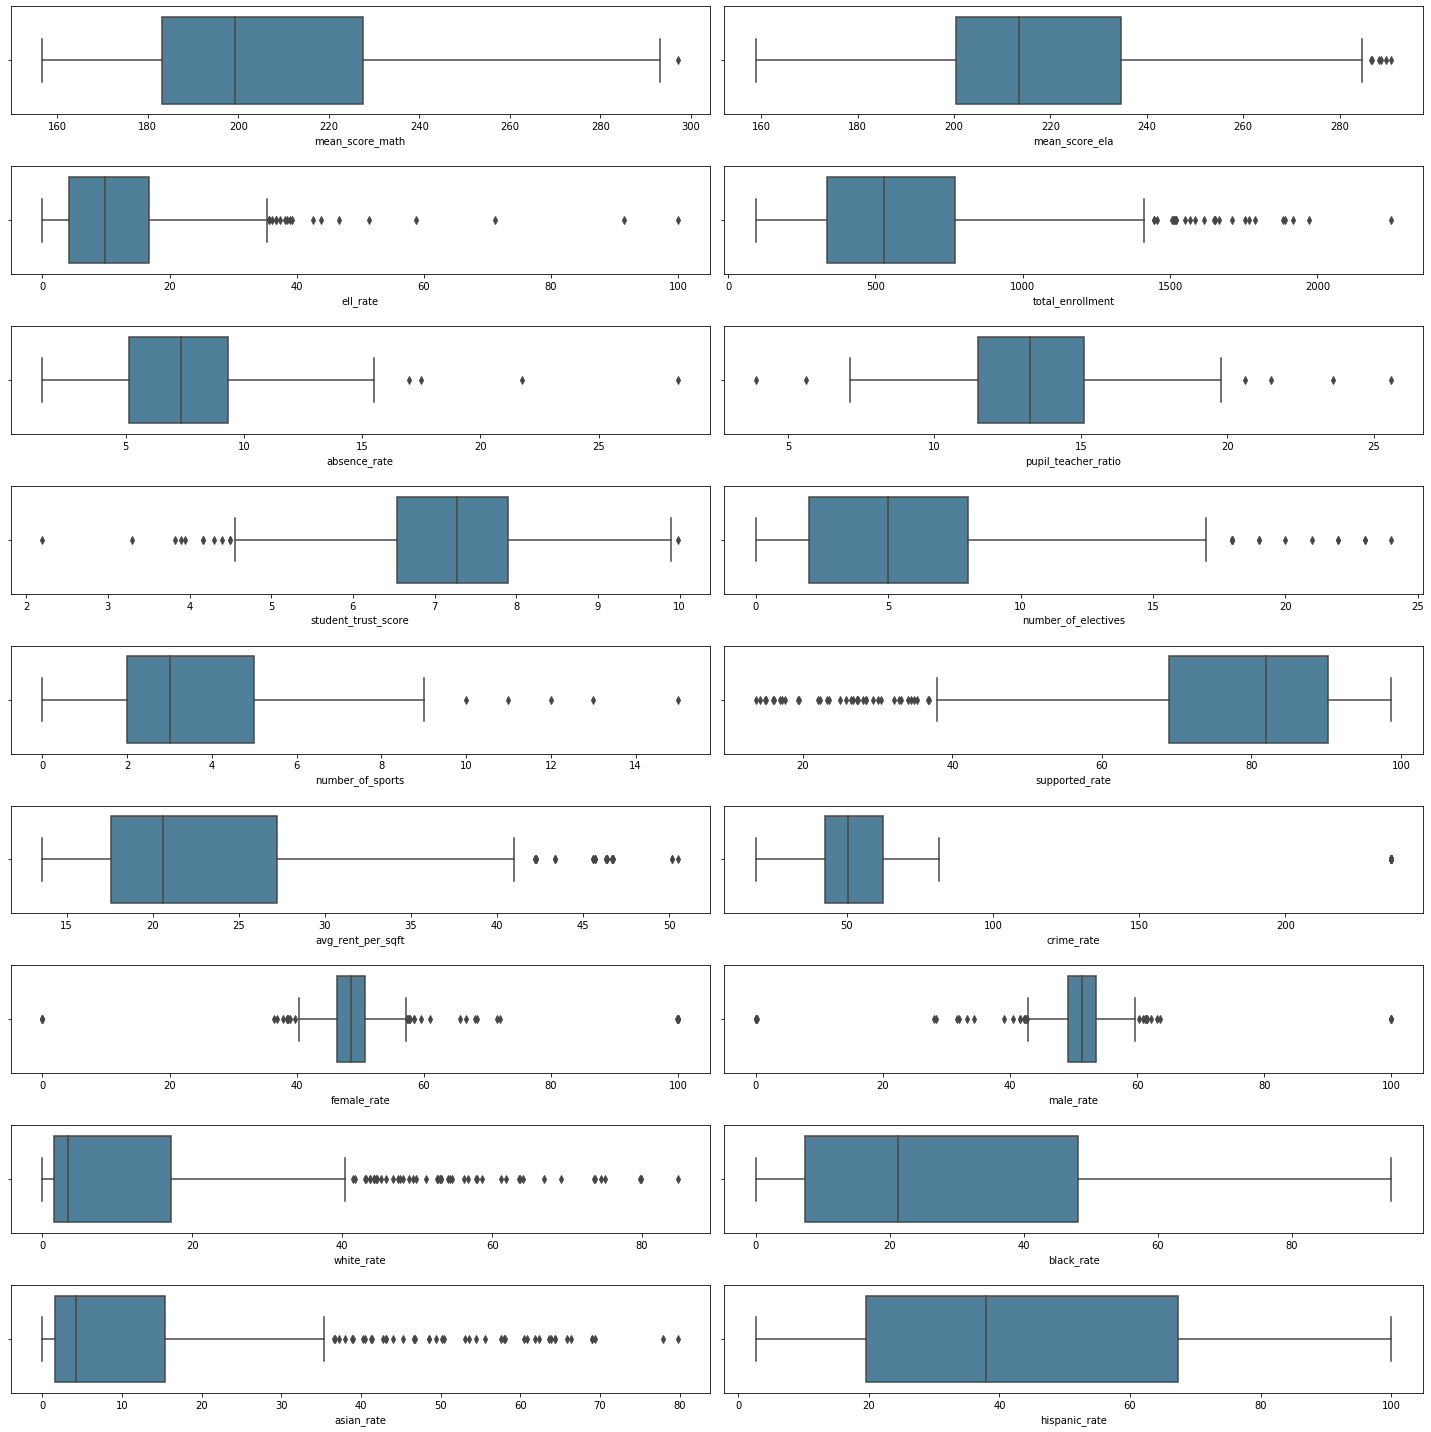

In [50]:
fig = plt.figure(figsize=(20, 20))
for (var, num) in zip(variables, range(1, len(variables)+1)):
    ax = fig.add_subplot(len(variables)/2, 2, num)
    sns.boxplot(eda_data[var], color='#2b8cbe', saturation=0.5)
plt.tight_layout(h_pad=2)

A lot of observations can be classified as outliers. We take a closer look at some of them, and what boroughs they are located in. 

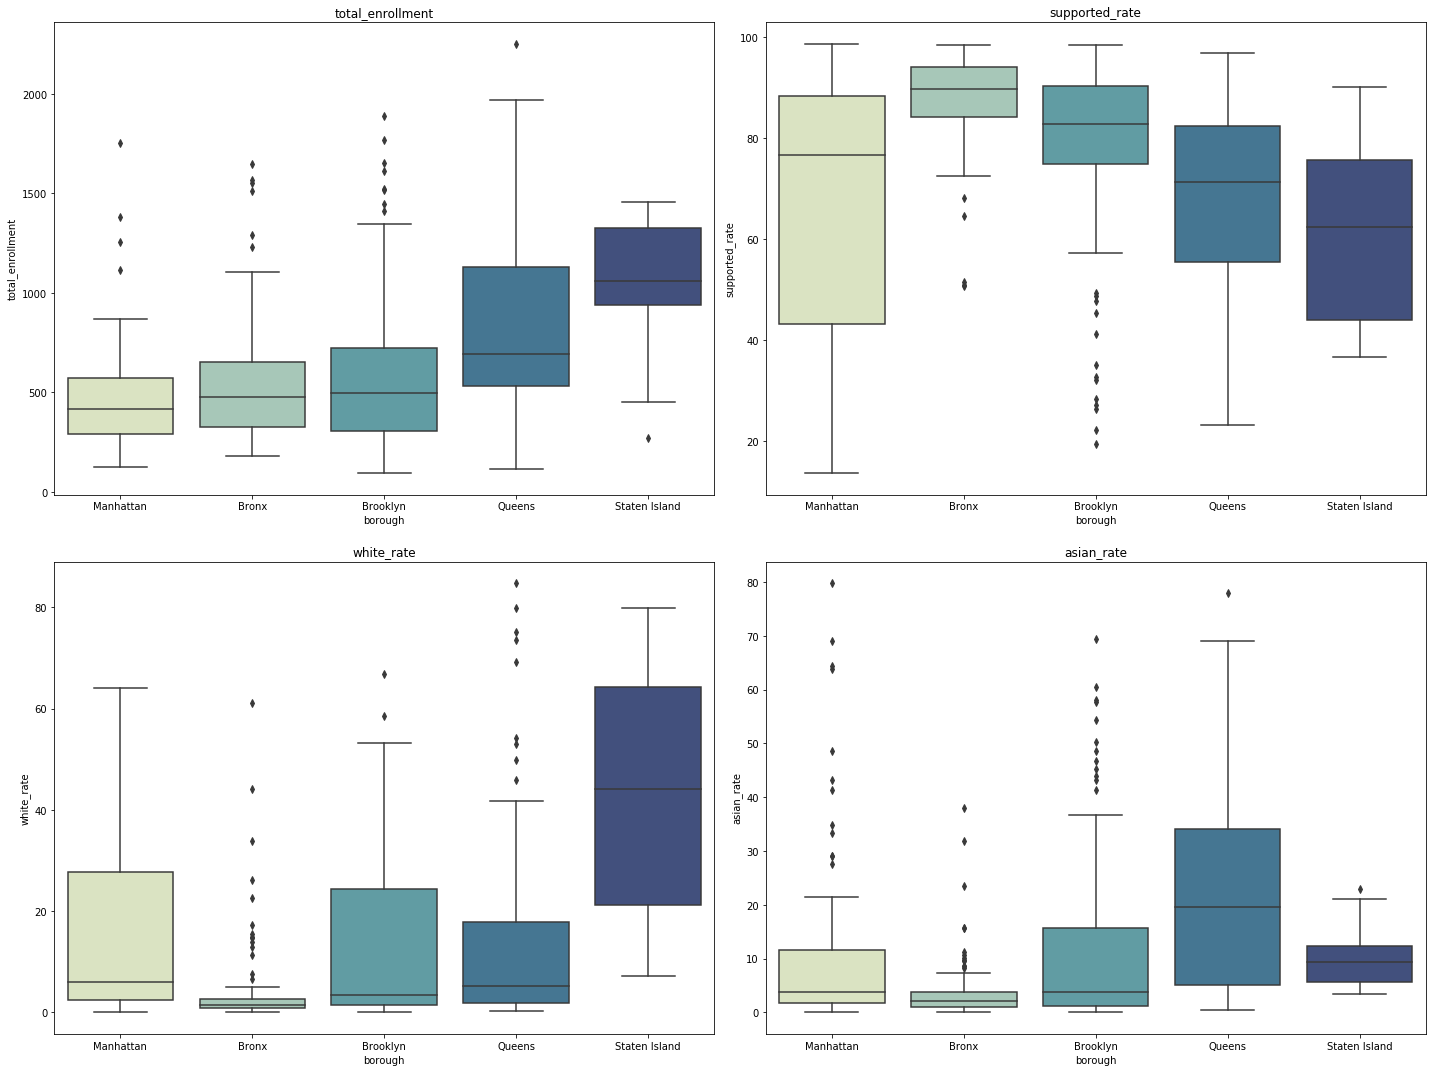

In [51]:
fig = plt.figure(figsize=(20,15))
selected = ['total_enrollment','supported_rate','white_rate','asian_rate']
for (var, num) in zip(selected, range(1, len(selected)+1)):
    ax = fig.add_subplot(len(selected)/2, 2, num)
    plt.title(var)
    sns.boxplot(x='borough', y=var, data=eda_data, palette='YlGnBu', saturation=0.5)
plt.tight_layout(h_pad=2)

It is often a good idea to remove outliers by performing e.g. the IQR score technique, as outliers can make machine learning models less accurate. However, our purpose of this preliminary analysis was simply to explore the data, so there is no need for removing them. Besides, since we are looking at differences of individual schools, it is actually quite interesting to include the outliers.

#### 2.3.4 Distribution of variables
To get an even better sense of how the numeric variables are distributed, we examined the univariate distributions. Seaborn's distplot() function is convenient for this purpose, as it by default draws a histogram and fit a kernel density estimate (KDE). In the examples below, we used the variable 'mean_score_math'.

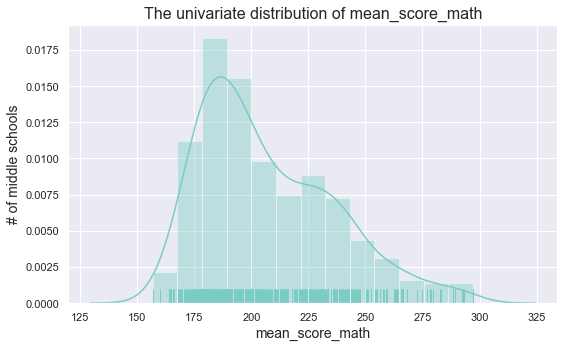

In [52]:
sns.set()
def plot_distribution(variable, hist, kde, rug, bins):
    fig = plt.figure(figsize=(8,5))
    plt.title('The univariate distribution of {}'.format(variable),fontsize=16)    
    sns.distplot(eda_data[variable], color='#7bccc4', hist=hist, kde=kde, rug=rug, bins=bins)
    plt.xlabel(variable, fontsize=14)
    plt.ylabel('# of middle schools', fontsize=14)
    plt.tight_layout(h_pad=2)
plot_distribution('mean_score_math', hist=True, kde=True, rug=True, bins=None)

The histogram shows the distribution by forming bins along the range of the data and drawing bars to show the number of observations that fall in each bin. This is illustrated above, where the rug plot draws a small vertical tick at each observation. The number of bins is here chosen by default using a common reference rule. We can also check for more/fewer bins to potentially reveal other features in the data.

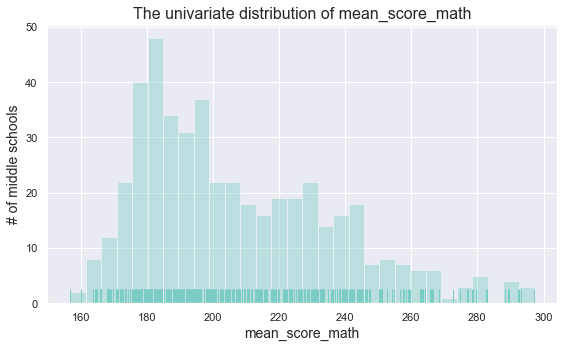

In [53]:
plot_distribution('mean_score_math', hist=True, kde=False, rug=True, bins=30)

It seems like distplot() made a pretty good guess. 

The kernel density estimate is used to plot the shape of the distribution. It replaces each observation with a Gaussian curve centered at that value, and the density at each point is then computed by summing these curves. Lastly, the resulting curve is normalized so that the area under it equals 1. 

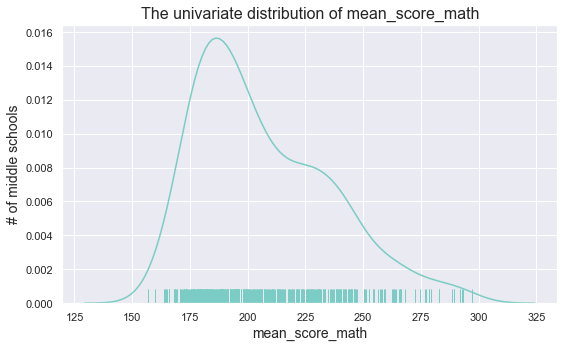

In [54]:
plot_distribution('mean_score_math', hist=False, kde=True, rug=True, bins=None)

This plot shows that one should be aware of how the KDE plots represent the data. E.g. it makes tails without there actually being data there, as seen above. Similar to the number of bins, the bandwith is here chosen by default. This parameter controls how tightly the estimation is fit to the data. Again, we check different bandwidths. 

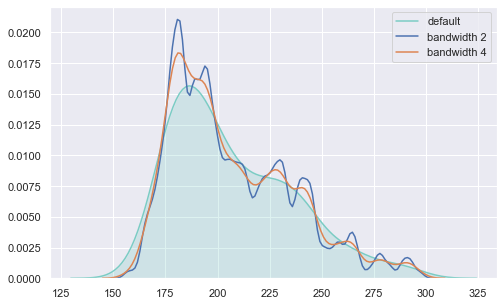

In [55]:
plt.figure(figsize=(8,5))
sns.kdeplot(eda_data['mean_score_math'], label='default', color='#7bccc4', shade=True)
sns.kdeplot(eda_data['mean_score_math'], bw=2, label="bandwidth 2")
sns.kdeplot(eda_data['mean_score_math'], bw=4, label="bandwidth 4")
plt.legend();

The remaining relevant variables are presented with the distplot() function in the following.

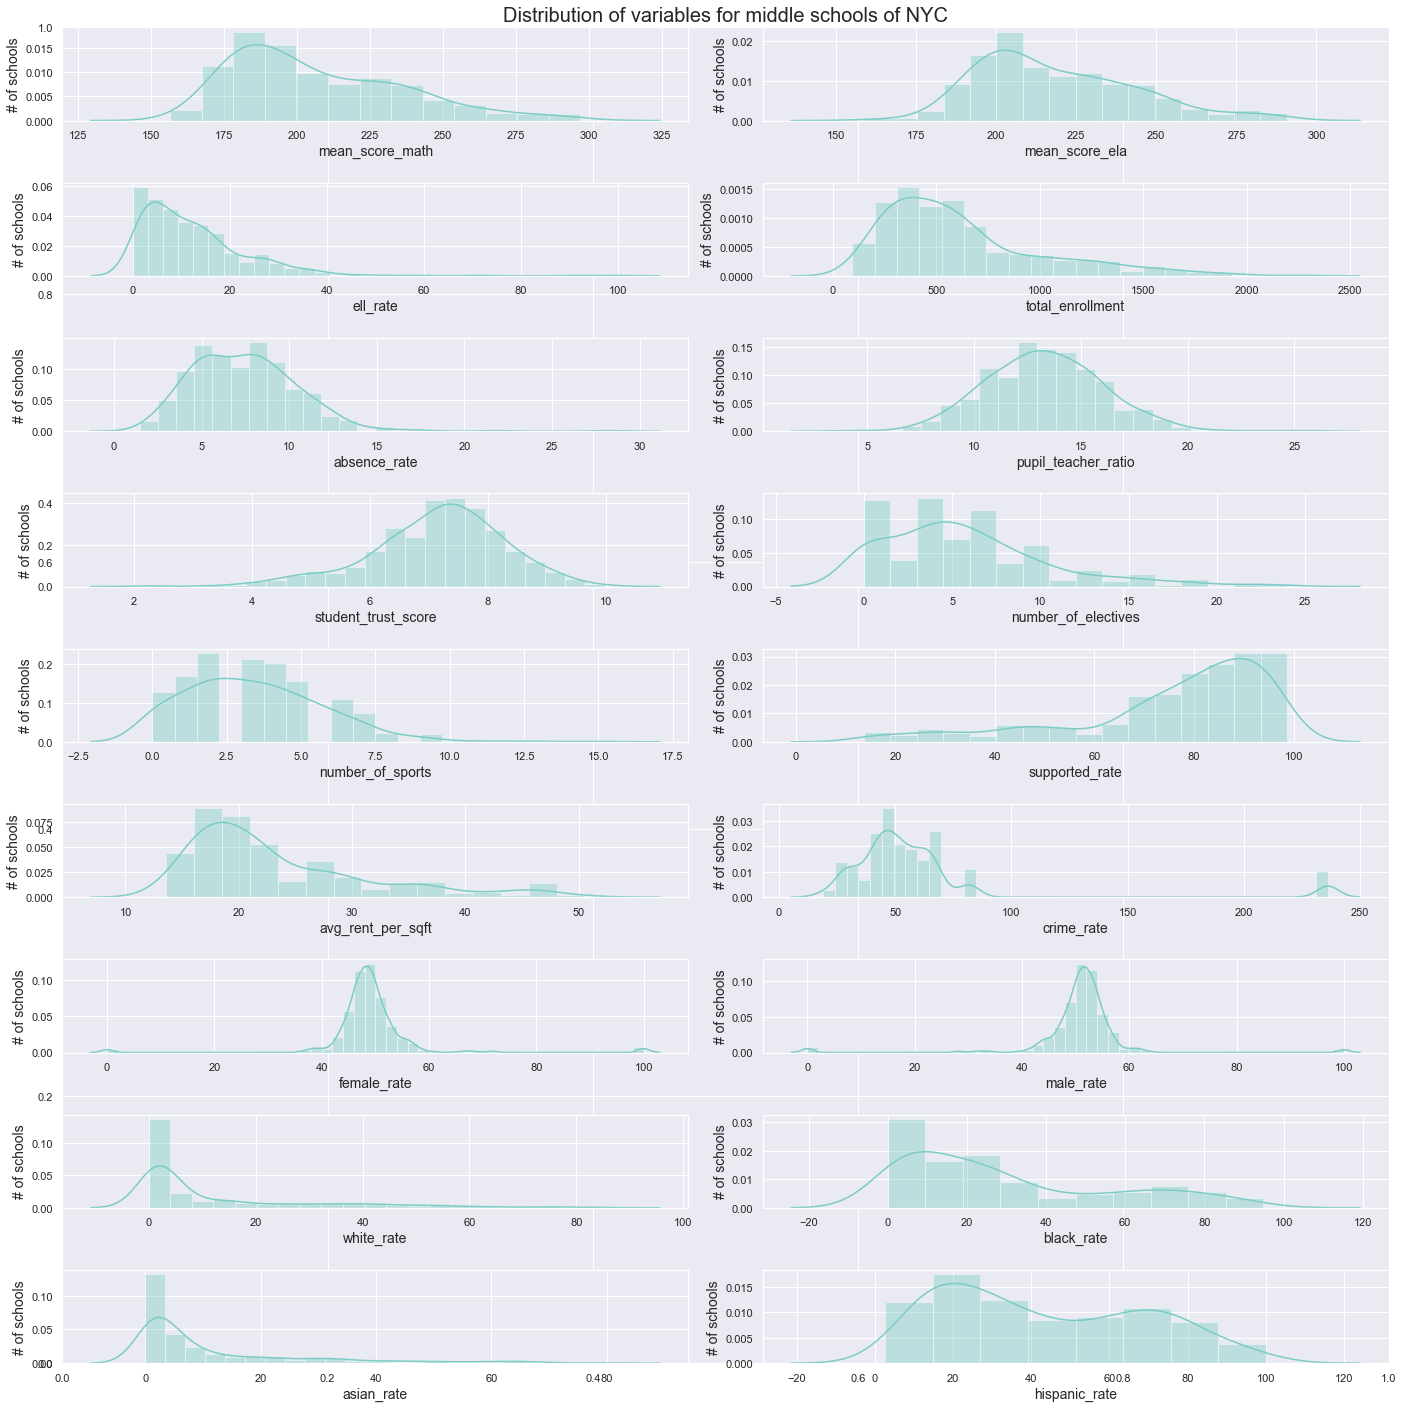

In [56]:
fig = plt.figure(figsize=(20, 20))
plt.title('Distribution of variables for middle schools of NYC', fontsize=20)
for (var, num) in zip(variables, range(1, len(variables)+1)):
    ax = fig.add_subplot(len(variables)/2, 2, num)
    sns.distplot(eda_data[var], color='#7bccc4')
    plt.xlabel(var, fontsize=14)
    plt.ylabel('# of schools', fontsize=14)
plt.tight_layout(h_pad=2)

It is observed that pupil_teacher_ratio, student_trust_score, female_rate and male_rate seem normally distributed. The math and ELA scores have quite similar, wide distributions, both being right skewed. The white rate and asian rate of students are also similar and right skewed, and have a more narrow range, compared to the black and hispanic rate. The crime rate have some outlier observations, which was also seen from the boxplots. 

#### 2.3.5 Correlation between variables
We investigated the different variables against one another to reveal potential pairwise relationships in the data. Firstly, we visualized the correlation matrix using a heat map.

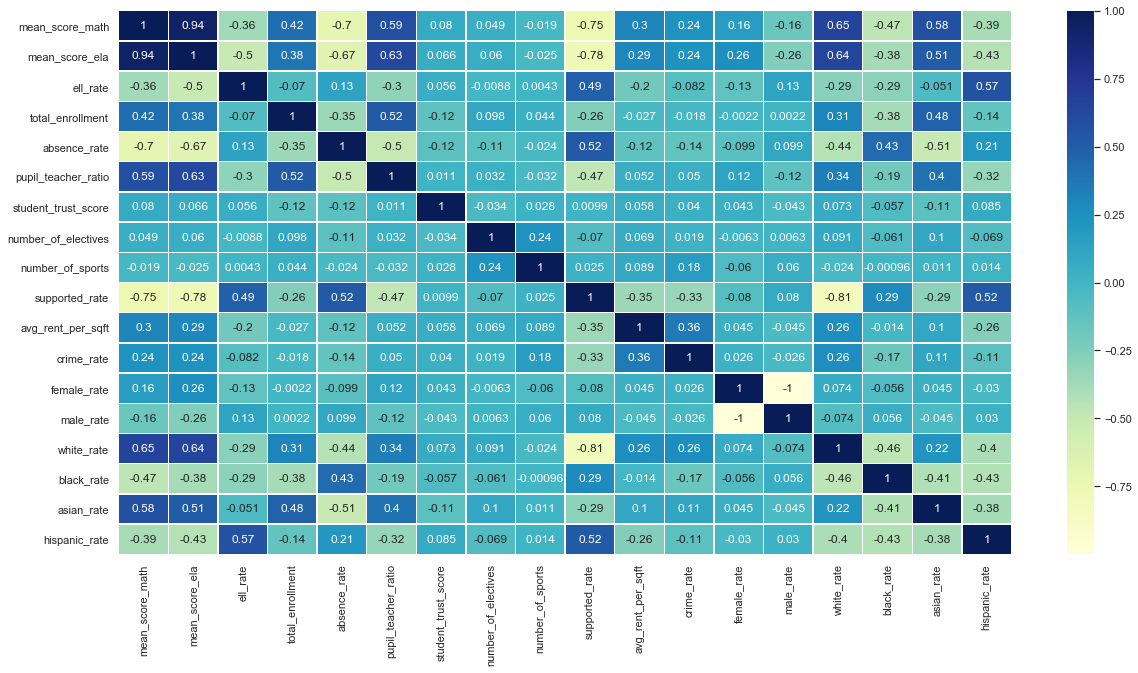

In [57]:
plt.figure(figsize=(20, 10))
c = eda_data[variables].corr()
sns.heatmap(c, cmap="YlGnBu", annot=True, linewidths=.5)
plt.show()

It is seen that the mean math and ELA score are dependent variables, which shows that if a school scores high in math, it also tends to score high on ELA. Absence rate is negatively correlated with the math and ELA scores, which makes sense since one typically expect worse results when being more absent from school. There also seems to be some relation between students being eligable for financial support and students performing well on the tests. Here it is worth mentioning that the white rate is negatively correlated with the financial support rate. An interesting last remark is that the asian and white rates are positively correlated with the test scores, as opposed to the black and hispanic rates. 

The same can be seen from the plots below, were Seaborn's pairplot() is used to plot multiple pairwise bivariate distributions, with scatter plots and KDE on the diagonal. We group by borough, to look at potential differences. 

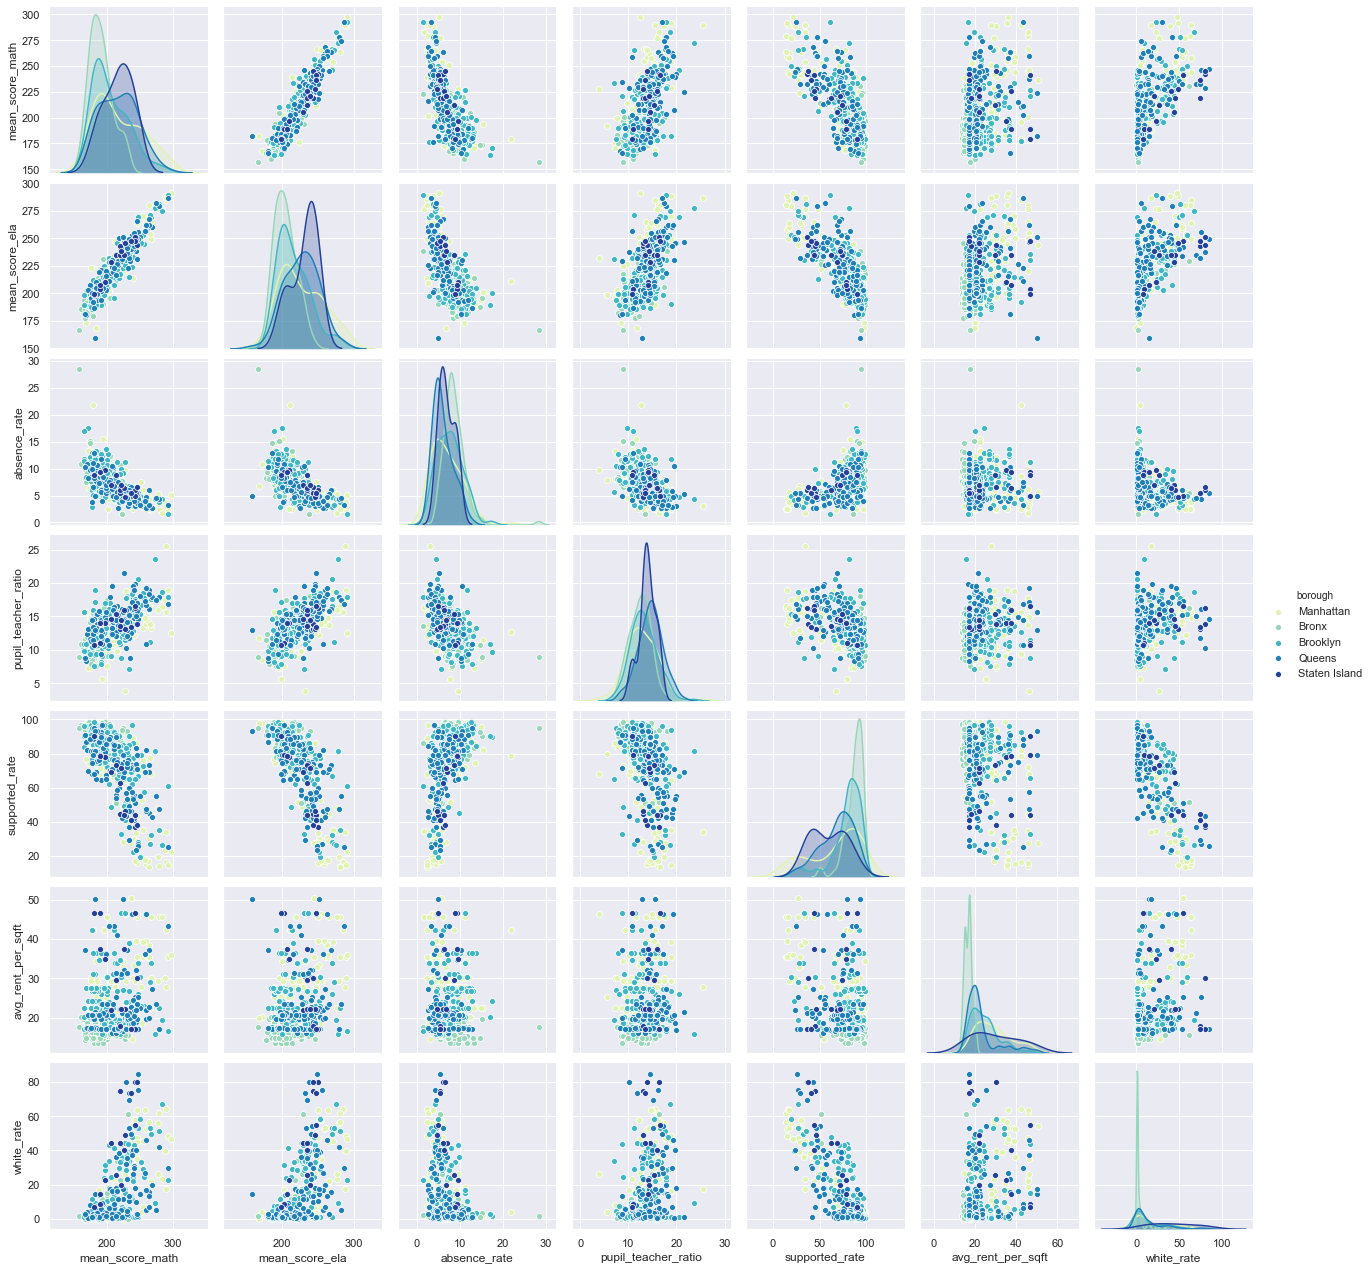

In [58]:
pair_variables = ['borough', 'mean_score_math', 'mean_score_ela', 'absence_rate', 'pupil_teacher_ratio', 'supported_rate', 'avg_rent_per_sqft', 'white_rate']
sns.pairplot(eda_data[pair_variables], hue='borough', diag_kind='kde', palette='YlGnBu')
plt.show()

#### 2.3.6 Counts
To explore the basic distribution of some of the categorical variables, we used the value_counts() function and visualized the frequencies using bar charts.

In [59]:
cat_vars = ['borough','neighborhood','district','open_year']
for var in cat_vars:
    print('\nNumber of schools per {}'.format(var)+'\n{}'.format(eda_data[var].value_counts())) 


Number of schools per borough
Brooklyn         141
Bronx            115
Queens           103
Manhattan         96
Staten Island     15
Name: borough, dtype: int64

Number of schools per neighborhood
East Harlem        12
Bushwick           12
East New York      11
Brownsville        10
Upper West Side     9
                   ..
Tottenville         1
Arverne             1
Bay Terrace         1
Clason Point        1
Hunters Point       1
Name: neighborhood, Length: 190, dtype: int64

Number of schools per district
10    26
9     24
2     24
27    23
11    20
3     20
6     19
29    17
8     16
12    16
17    16
21    15
30    15
23    15
20    15
19    15
31    15
4     14
25    14
24    14
7     13
28    13
15    11
32    10
13    10
14    10
22    10
5     10
1      9
18     9
26     7
16     5
Name: district, dtype: int64

Number of schools per open_year
1999    44
2004    27
2005    19
2006    18
2009    17
        ..
1976     1
1974     1
1973     1
1961     1
1897     1
Name: ope

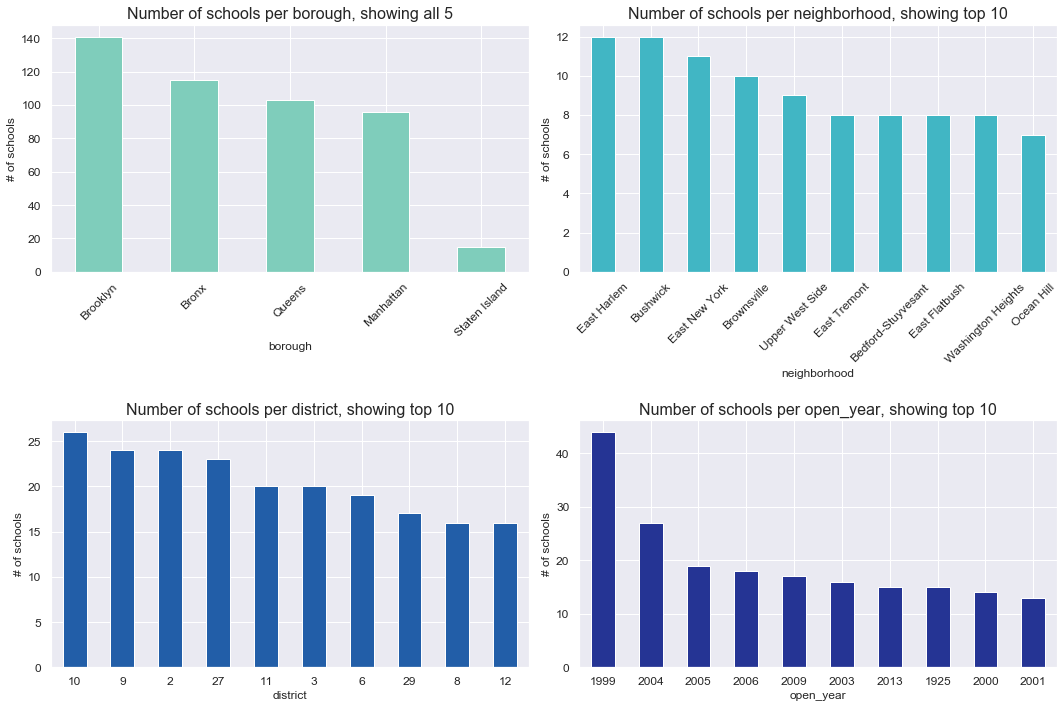

In [60]:
fig = plt.figure(figsize=(15, 10))
colors=['#7fcdbb', '#41b6c4', '#225ea8', '#253494']
for (var,num) in zip(cat_vars, range(1, len(cat_vars)+1)):
    ax = fig.add_subplot(len(cat_vars)/2, 2, num)
    eda_data[var].value_counts().nlargest(10).plot.bar(color=colors[num-1], fontsize=12)
    if len(eda_data[var].unique()) > 10:
        plt.title('Number of schools per {}, showing top 10'.format(var), fontsize=16)
    else:
        plt.title('Number of schools per {}, showing all 5'.format(var), fontsize=16)
    plt.xlabel(var, fontsize=12)
    plt.ylabel('# of schools', fontsize=12)
    if num < 3:
        plt.xticks(rotation=45)
    else:
        plt.xticks(rotation='horizontal')
plt.tight_layout(h_pad=2)

It can be seen that Brooklyn is the borough with most public middle schools whereas Staten Island has the fewest. The plot showing the top ten years for opening schools shows that most schools were opened in 1999. 

## 3. Data Analysis

### 3.1 Analysis and findings
*Describe your data analysis and explain what you've learned about the dataset.*

Some overall findings were described in the previous section, however now we narrow our analysis to focus on the boroughs. We have made several bar charts to compare the boroughs for different variables. Bar charts are chosen because a user easily can see which categories (here boroughs) score high and low on different measures. These helped finding patterns regarding the different boroughs based on demographics and performance measures. But first, we wanted an overview of the total number of schools in the districts and boroughs, as well as the sizes of the schools and classes. 

Besides comparing the boroughs with each other, we have also looked at temporal data for all boroughs combined and plotted the evolution of a specific attribute over time. Here, line plots are used because this visualization serves well since small changes over time can easier be seen in a line plot. For the trend lines for all boroughs combined it is important to be aware of *Simpsons’s paradox*. In these plots there are no downward- or upward trends, but if you look at the schools individually, trends appear. Hence, in the bokeh application that shows information about a specific school we have decided to include trend lines for the given school. 

All plots are made using *Bokeh* in order to enable interaction with the plots, e.g. with a hovertool. These visualizations are also included on the overview page on the website.

In [61]:
mid_dyn = pd.read_csv("../data/MiddleSchools_2006-2018_clean.csv")
mid_stat = pd.read_csv("../data/MiddleSchools_2018_clean.csv")

# assign a color for each borough in the two datasets
colors = ['#7bccc4', '#4eb3d3', '#2b8cbe', '#0868ac', '#084081']
C = []
for boro in mid_stat['borough']:
    if boro == 'Bronx':
        C.append(colors[0])
    elif boro == 'Brooklyn':
        C.append(colors[1])
    elif boro == 'Manhattan':
        C.append(colors[2])
    elif boro == 'Queens':
        C.append(colors[3])
    elif boro == 'Staten Island':
        C.append(colors[4])
mid_stat['colors'] = C
C = []
for boro in mid_dyn['borough']:
    if boro == 'Bronx':
        C.append(colors[0])
    elif boro == 'Brooklyn':
        C.append(colors[1])
    elif boro == 'Manhattan':
        C.append(colors[2])
    elif boro == 'Queens':
        C.append(colors[3])
    elif boro == 'Staten Island':
        C.append(colors[4])
mid_dyn['colors'] = C

# make sorting variable
sorter = ['Manhattan','Bronx', 'Brooklyn', 'Queens', 'Staten Island']
sorterIndex = dict(zip(sorter,range(len(sorter))))
mid_stat['rank'] = mid_stat['borough'].map(sorterIndex)
mid_dyn['rank'] = mid_dyn['borough'].map(sorterIndex)

# yearly
year= mid_dyn.groupby(['year']).mean().reset_index().drop(columns=['rank'])
year_dict = year.to_dict('list')
src_year = ColumnDataSource(year_dict) 

# mean
boro_mean = mid_stat.groupby(['rank','borough','colors']).mean().reset_index().drop(columns=['rank'])
boros = list(boro_mean['borough'])
mean_dict= boro_mean.to_dict('list')
src_mean = ColumnDataSource(mean_dict) 

# sum
boro_sum= mid_stat.groupby(['rank','borough','colors']).sum().reset_index().rename(columns={0:'count'}).drop(columns=['rank'])
sum_dict= boro_sum.to_dict('list')
src_sum = ColumnDataSource(sum_dict) 

# size by district AND borough
boro_size1= mid_stat.groupby(['rank','borough','district','colors']).size().reset_index().rename(columns={0:'count'}).drop(columns=['rank'])
boro_size1['district_str'] = boro_size1['district'].astype(str)
size_dict1= boro_size1.to_dict('list')
src_size1 = ColumnDataSource(size_dict1) 

boro_size2= mid_stat.groupby(['rank','borough','colors']).size().reset_index().rename(columns={0:'count'}).drop(columns=['rank'])
size_dict2= boro_size2.to_dict('list')
src_size2 = ColumnDataSource(size_dict2) 

#### 3.1.1 Schools per district and boroughs
First we plot how many public middle schools there are in each of the 32 school districts. The colors indicate which borough each of the districts belongs to. Next, we plot the total number of schools in each borough. 

In [62]:
print('Number of Middle Schools: ' + str(len(mid_stat)))
print('Total Enrollment: ' + str(mid_stat['total_enrollment'].sum()))

boro = boro_size1['borough'].values

tit = 'Schools by District'
xlab = 'Districts'

plot1 = figure(y_range=(0, 30), plot_width=600, plot_height=300,
               x_axis_label=xlab, toolbar_location=None, title=tit)
plot1.vbar(x='district', width=0.7, bottom=0,
           top='count', color='colors', source=size_dict1)
#plot.vbar(x=dist, width=0.9, bottom=0,top=boro_size1['count'].values, color=boro_size1['colors'].values, source=src_size1)

# hover tool
plot1.add_tools(HoverTool(tooltips=[('Borough', "@borough"), ('District', "@district_str{1}"), ('Schools', "@count{1}")]))

# axis ticks
plot1.xaxis.major_tick_line_color = None 
plot1.xaxis.minor_tick_line_color = None 
plot1.yaxis.major_tick_line_color = None  
plot1.yaxis.minor_tick_line_color = None  
plot1.xaxis.ticker = list(range(1, 33))
plot1.title.text_font_size = '13pt'
plot1.title.align = 'center'

boro2 = boro_size2['borough'].values
tit = 'Schools by Borough'

plot2 = figure(x_range=FactorRange(factors=boro2), plot_width=600, plot_height=300,
               toolbar_location=None, title=tit)
plot2.vbar(x='borough', width=0.7, bottom=0,
           top='count', color='colors', source=src_size2)
#plot.vbar(x=dist, width=0.9, bottom=0,top=boro_size1['count'].values, color=boro_size1['colors'].values, source=src_size1)

# hover tool
plot2.add_tools(HoverTool(tooltips=[('Schools', "@count{1}")]))

# axis ticks
plot2.xaxis.major_tick_line_color = None  
plot2.xaxis.minor_tick_line_color = None  
plot2.yaxis.major_tick_line_color = None  
plot2.yaxis.minor_tick_line_color = None  
plot2.title.text_font_size = '13pt'
plot2.title.align = 'center'
plot2.xaxis.axis_label_text_font_size = "25pt"

layout = column(plot1, plot2)
output_notebook()
show(layout)

Number of Middle Schools: 470
Total Enrollment: 293227


Loading BokehJS ...

![](https://github.com/nyc-public-schools/nyc-public-schools.github.io/blob/master/images/plot1.png?raw=true)


Staten Island only has one school district and hence, there are significantly fewer schools. School district 32 stands out as it is a relatively new school district in NYC. 

#### 3.1.2 Total Enrollment and Class size
Now we plot the total number of students enrolled in a public middle school in each of the boroughs and the average class size in each borough. This is calculated as the student-teacher ratio.

In [63]:
# total enrollment
boro2 = boro_sum['borough'].values
tit = 'Enrolled Students by Borough'

plot3 = figure(x_range=FactorRange(factors=boro2),plot_width=600, plot_height=300,\
               toolbar_location=None, title=tit)
plot3.vbar(x='borough', width=0.7, bottom=0,top='total_enrollment', color='colors',source=src_sum,)
#plot.vbar(x=dist, width=0.9, bottom=0,top=boro_size1['count'].values, color=boro_size1['colors'].values, source=src_size1)

# hover tool
plot3.add_tools(HoverTool(tooltips=[('Enrolled',"@total_enrollment{1}")]))

# axis ticks
plot3.xaxis.major_tick_line_color = None  
plot3.xaxis.minor_tick_line_color = None  
plot3.yaxis.major_tick_line_color = None  
plot3.yaxis.minor_tick_line_color = None 
plot3.title.text_font_size = '13pt'
plot3.title.align = 'center'
plot3.xaxis.axis_label_text_font_size = "25pt"

# class size
boro2 = boro_mean['borough'].values
tit = 'Average Class Size by Borough'

plot4 = figure(x_range=FactorRange(factors=boro2),plot_width=600, plot_height=300,\
               toolbar_location=None, title=tit)
plot4.vbar(x='borough', width=0.7, bottom=0,top='pupil_teacher_ratio', color='colors',source=src_mean,)
#plot.vbar(x=dist, width=0.9, bottom=0,top=boro_size1['count'].values, color=boro_size1['colors'].values, source=src_size1)

# hover tool
plot4.add_tools(HoverTool(tooltips=[('Class size',"@pupil_teacher_ratio{1.1}")]))

# axis ticks
plot4.xaxis.major_tick_line_color = None  
plot4.xaxis.minor_tick_line_color = None 
plot4.yaxis.major_tick_line_color = None  
plot4.yaxis.minor_tick_line_color = None 
plot4.title.text_font_size = '13pt'
plot4.title.align = 'center'
plot4.xaxis.axis_label_text_font_size = "25pt"

layout = column(plot3,plot4)
output_notebook()
show(layout)

Loading BokehJS ...

![](https://github.com/nyc-public-schools/nyc-public-schools.github.io/blob/master/images/plot2.png?raw=true)


The average class sizes are very similar across the boroughs with the smallest being Bronx's average on 12.5 and the largest being Queens's average with 14.7.

#### 3.1.3 Etnicities per borough and overall trend across boroughs

Now we plot the percentage of each etnicity in the schools in each borough and the overall development in the percentage of etnicities, respectively. These percentages are based on the number of students from each etnicity that is enrolled in the public middle schools and is therefore not necessarily an indication of the general trend in each borough. In fact, etnicities with a low representation in these plot might be an indication of these groups being more willing to choose private schools.

In [64]:
tit = 'Etnicity by Borough'

boro2 = mean_dict['borough']
etni = ['other_rate', 'asian_rate', 'white_rate', 'black_rate', 'hispanic_rate']
etni_lab = ['Other', 'Asian', 'White', 'Black', 'Hispanic']

plot5 = figure(y_range=(0, 130), x_range=boro2, plot_width=600, plot_height=300,
               title=tit, y_axis_label='%', toolbar_location=None, tools="")

renderers = plot5.vbar_stack(etni, x='borough', width=0.9,
                             color=colors, source=mean_dict, legend_label=etni_lab)

for r, e in zip(renderers, etni_lab):
    et = e
    re = r.name
    hover = HoverTool(tooltips=[("%s" % et, "@%s{1.1}" % re + '%')], renderers=[r])
    plot5.add_tools(hover)

plot5.y_range.start = 0
plot5.x_range.range_padding = 0.1
plot5.xgrid.grid_line_color = None
plot5.axis.minor_tick_line_color = None
plot5.outline_line_color = None
plot5.yaxis.ticker = [0, 20, 40, 60, 80, 100]
plot5.legend.location = "top_center"
plot5.legend.label_text_font_size = "7pt"
plot5.legend.orientation = "horizontal"
plot5.title.text_font_size = '13pt'
plot5.title.align = 'center'

tit = 'Trend of Etnicities across Boroughs'

etni = ['other_rate', 'asian_rate', 'white_rate', 'black_rate', 'hispanic_rate']
etni_lab = ['Other', 'Asian', 'White', 'Black', 'Hispanic']

plot6 = figure(plot_width=600, plot_height=300, y_range=(0, 55), title=tit,
               y_axis_label='%', toolbar_location=None, tools="")

for i in range(len(etni)):
    line = plot6.line(x='year', y=etni[i], line_width=2,
                      source=src_year, color=colors[i], legend_label=etni_lab[i])
    plot6.circle(x='year', y=etni[i], size=5, source=src_year, color=colors[i])
    hover = HoverTool(renderers=[line])
    hover.tooltips = [
        ('Year', '@year'),
        (etni_lab[i], '@'+etni[i]+'{1.1} %')
    ]
    plot6.add_tools(hover)

plot6.xgrid.grid_line_color = None
plot6.axis.minor_tick_line_color = None
plot6.outline_line_color = None
plot6.legend.location = "top_center"
plot6.legend.label_text_font_size = "8pt"
plot6.legend.orientation = "horizontal"
plot6.title.text_font_size = '13pt'
plot6.title.align = 'center'

layout = column(plot5, plot6)
output_notebook()
show(layout)

Loading BokehJS ...

![](https://github.com/nyc-public-schools/nyc-public-schools.github.io/blob/master/images/plot4.png?raw=true)


The plots show that there is a high percentage of hispanic students on the public middle schools in all boroughs. This could indicate that people with this etnicity in general do not send their children to private schools. It is also shown that Bronx is the borough with the highest percentage of black students in public middle schools, while Staten Island has the highest percentage of white public middle school students. 

#### 3.1.4 Gender per borough and overall trend across boroughs
Next, we plot the average female/male distribution on the schools in each borough and the overall development of the female/male distribution from 2006-2018 for all boroughs combined.  

In [65]:
tit = 'Gender by Borough'

boro2 = mean_dict['borough']
g = ['female_rate', 'male_rate']
g_lab = ['Female', 'Male']

colors = ['#4eb3d3','#084081']

plot7 = figure(y_range=(0, 130), x_range=boro2, plot_width=600, plot_height=300,
               title=tit, y_axis_label='%', toolbar_location=None, tools="")

renderers = plot7.vbar_stack(g, x='borough', width=0.9, color=colors, source=mean_dict, legend_label=g_lab)

for r, e in zip(renderers, g_lab):
    et = e
    re = r.name
    hover = HoverTool(tooltips=[("%s" % et, "@%s{1.1}" % re + '%')], renderers=[r])
    plot7.add_tools(hover)

plot7.y_range.start = 0
plot7.x_range.range_padding = 0.1
plot7.xgrid.grid_line_color = None
plot7.axis.minor_tick_line_color = None
plot7.outline_line_color = None
plot7.yaxis.ticker = [0, 20, 40, 60, 80, 100]
plot7.legend.location = "top_center"
plot7.legend.label_text_font_size = "7pt"
plot7.legend.orientation = "horizontal"
plot7.title.text_font_size = '13pt'
plot7.title.align = 'center'

tit = 'Trend of Gender across Boroughs'

plot8 = figure(y_range=(45, 55), plot_width=600, plot_height=300, title=tit, y_axis_label='%',
               toolbar_location=None, tools="")

for i in range(len(g)):
    line = plot8.line(x='year', y=g[i], line_width=2,
                      source=src_year, color=colors[i], legend_label=g_lab[i])
    plot8.circle(x='year', y=g[i], size=5, source=src_year, color=colors[i])
    hover = HoverTool(renderers=[line])
    hover.tooltips = [
        ('Year', '@year'),
        (g_lab[i], '@'+g[i]+'{1.1} %')
    ]
    plot8.add_tools(hover)

plot8.xgrid.grid_line_color = None
plot8.axis.minor_tick_line_color = None
plot8.outline_line_color = None
plot8.legend.location = "top_center"
plot8.legend.label_text_font_size = "8pt"
plot8.legend.orientation = "horizontal"
plot8.title.text_font_size = '13pt'
plot8.title.align = 'center'

layout = column(plot7, plot8)
output_notebook()
show(layout)

Loading BokehJS ...

![](https://github.com/nyc-public-schools/nyc-public-schools.github.io/blob/master/images/plot3.png?raw=true)


The plots show that there is no remarkable difference in the gender distribution. However, we have also looked at specific schools, which showed that there exist all-girls schools, which cannot be told from the plot. 

In [66]:
print(f"Number of all-girls schools: {len(mid_stat[mid_stat['female_rate'] == 100])}")
mid_stat.school_name[mid_stat['female_rate'] == 100]

Number of all-girls schools: 6


64                  Young Women's Leadership School
148    Young Women's Leadership School of the Bronx
230     Young Women's Leadership School of Brooklyn
300      Urban Assembly School for Criminal Justice
412         Young Women's Leadership School, Queens
442        Young Women's Leadership School, Astoria
Name: school_name, dtype: object

#### 3.1.5 Rental and crime rate per borough
Now we look at rental prices and crimes based on the categories mentioned earlier. 

In [67]:
rc_boro = mid_stat.groupby(['borough']).agg({'avg_rent_per_sqft': ['min', 'mean', 'max'],
                                             'crime_rate': ['min', 'mean', 'max']}).reset_index()
# make rental levels dummy variables
mid_stat['rent_level_str'] = mid_stat['rent_level'].astype(str).str.slice(0, 1)
rent1 = pd.concat([mid_stat['borough'], pd.get_dummies(
    mid_stat['rent_level_str'])], axis=1)
rent_df2 = rent1.groupby('borough').sum().reset_index()
rent_df2['total'] = rent_df2.sum(axis=1)
rent_df2['lev1'] = round(rent_df2['1']/rent_df2['total']*100, 1)
rent_df2['lev2'] = round(rent_df2['2']/rent_df2['total']*100, 1)
rent_df2['lev3'] = round(rent_df2['3']/rent_df2['total']*100, 1)

rent_dict = rent_df2.to_dict('list')

tit = 'Rental per Sqft in intervals '
boro2 = mean_dict['borough']
g = ['lev1', 'lev2', 'lev3']
g_lab = ['<20 $ per sqft', '20-30 $ per sqft', '>30 $ per sqft']

colors = ['#4eb3d3', '#0868ac', '#084081']

plot9 = figure(y_range=(0, 130), x_range=boro2, plot_width=600, plot_height=300, 
               title=tit, y_axis_label='%', toolbar_location=None, tools="")

renderers = plot9.vbar_stack(g, x='borough', width=0.9, color=colors, source=rent_dict, legend_label=g_lab)

for r, e in zip(renderers, g_lab):
    et = e
    re = r.name
    hover = HoverTool(tooltips=[
        ("%s" % et, "@%s{1.1}" % re + '%'),
    ], renderers=[r])
    plot9.add_tools(hover)

plot9.y_range.start = 0
plot9.x_range.range_padding = 0.1
plot9.xgrid.grid_line_color = None
plot9.axis.minor_tick_line_color = None
plot9.outline_line_color = None
plot9.yaxis.ticker = [0, 20, 40, 60, 80, 100]
plot9.legend.location = "top_center"
plot9.legend.label_text_font_size = "7pt"
plot9.legend.orientation = "horizontal"
plot9.title.text_font_size = '13pt'
plot9.title.align = 'center'

# make crimes levels dummy variables
mid_stat['crime_level_str'] = mid_stat['crime_level'].astype(
    str).str.slice(0, 1)
crime1 = pd.concat([mid_stat['borough'], pd.get_dummies(
    mid_stat['crime_level_str'])], axis=1)
crime2 = crime1.groupby('borough').sum().reset_index()
crime2['total'] = crime2.sum(axis=1)

crime2['lev1'] = round(crime2['1']/crime2['total']*100, 1)
crime2['lev2'] = round(crime2['2']/crime2['total']*100, 1)
crime2['lev3'] = round(crime2['3']/crime2['total']*100, 1)

crime_dict = crime2.to_dict('list')

tit = 'Crimes per 100.000 citizen in intervals '

boro2 = mean_dict['borough']
g = ['lev1', 'lev2', 'lev3']
g_lab = ['<30 felonies per 100.000',
         '30-60 felonies per 100.000', '>60 felonies per 100.000']

colors = ['#4eb3d3', '#0868ac', '#084081']

plot10 = figure(y_range=(0, 130), x_range=boro2, plot_width=600, plot_height=300, 
                title=tit, y_axis_label='%', toolbar_location=None, tools="")

renderers = plot10.vbar_stack(g, x='borough', width=0.9, color=colors, source=crime_dict, legend_label=g_lab)

for r, e in zip(renderers, g_lab):
    et = e
    re = r.name
    hover = HoverTool(tooltips=[
        ("%s" % et, "@%s{1.1}" % re + '%'),
    ], renderers=[r])
    plot10.add_tools(hover)

plot10.y_range.start = 0
plot10.x_range.range_padding = 0.1
plot10.xgrid.grid_line_color = None
plot10.axis.minor_tick_line_color = None
plot10.outline_line_color = None
plot10.yaxis.ticker = [0, 20, 40, 60, 80, 100]
plot10.legend.location = "top_right"
plot10.legend.label_text_font_size = "7pt"
plot10.legend.orientation = "horizontal"
plot10.title.text_font_size = '13pt'
plot10.title.align = 'center'

layout = column(plot9, plot10)
output_notebook()
show(layout)

Loading BokehJS ...

![](https://github.com/nyc-public-schools/nyc-public-schools.github.io/blob/master/images/plot5.png?raw=true)


The plots indicate that there is a negative correlation between rental prices and crime rates. Bronx is the borough with the lowest rental prices but is also the borough with the highest number of crimes. In comparison, Manhattan has a high percentage of schools located in areas with a high rental price and is also the borough with most schools located in areas with less than 30 felonies per 100.000.

#### 3.1.6 Perfomance Math and ELA, as well as Absence 
Now the average ELA- and Math score in each borough are plotted, together with a trend line for the average ELA- and Math score based on the results for all boroughs combined. We also plot the absence rates for each borough. 

In [68]:
tit = 'Mean Scores by Borough'
boro2 = boro_size2['borough'].values
years = ['mean_score_math', 'mean_score_ela']
lab = ['Math Score', 'ELA Score']
colors = (['#2b8cbe', '#7bccc4', '#4eb3d3', '#0868ac', '#084081'])

x = [(b, l) for b in boro2 for l in lab]
counts = sum(zip(boro_mean['mean_score_math'],
                 boro_mean['mean_score_ela']), ())  # like an hstack
col = sum(zip(colors, colors), ())  # like an hstack

source = ColumnDataSource(data=dict(x=x, counts=counts, colors=col))

p = figure(x_range=FactorRange(*x), plot_width=600, plot_height=320, 
           title=tit, toolbar_location=None, tools="")

renderers = p.vbar(x='x', top='counts', width=0.9, source=source, color='colors')

p.add_tools(HoverTool(tooltips=[('Score', "@counts{1}")]))

p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xaxis.major_label_orientation = 1
p.xgrid.grid_line_color = None
p.xaxis.major_tick_line_color = None
p.xaxis.minor_tick_line_color = None
p.yaxis.major_tick_line_color = None
p.yaxis.minor_tick_line_color = None
p.title.text_font_size = '13pt'
p.title.align = 'center'
p.xaxis.axis_label_text_font_size = "25pt"


tit = 'Trend of Mean Scores across Boroughs'
colors = ['#4eb3d3', '#084081']

p2 = figure(y_range=(150, 300), plot_width=600, plot_height=320,
            title=tit, y_axis_label='Score', toolbar_location=None, tools="")

for i in range(len(years)):
    line = p2.line(x='year', y=years[i], line_width=2,
                   source=src_year, color=colors[i], legend_label=lab[i])
    p2.circle(x='year', y=years[i], size=5, source=src_year, color=colors[i])
    hover = HoverTool(renderers=[line])
    hover.tooltips = [('Year', '@year'), (lab[i], '@'+years[i]+'{1.1} %')]
    p2.add_tools(hover)

p2.xgrid.grid_line_color = None
p2.axis.minor_tick_line_color = None
p2.outline_line_color = None
p2.legend.location = "top_center"
p2.legend.label_text_font_size = "8pt"
p2.legend.orientation = "horizontal"
p2.title.text_font_size = '13pt'
p2.title.align = 'center'

layout = column(p, p2)
output_notebook()
show(layout)

Loading BokehJS ...

![](https://github.com/nyc-public-schools/nyc-public-schools.github.io/blob/master/images/plot6.png?raw=true)


The first plot shows that the average scores in the boroughs are quite close to each other. Bronx both has the lowest average math score and ELA score with 191 and 205, respectively. In general it appears that the score on the ELA is consistently a bit higher than the math score. 

In [69]:
tit = 'Absence by Borough'

plot12 = figure(y_range=(0, 12), x_range=FactorRange(factors=boro2), plot_width=600, plot_height=300, 
                y_axis_label='%', toolbar_location=None, title=tit)
plot12.vbar(x='borough', width=0.7, bottom=0, top='absence_rate', color='colors', source=src_mean,)

# hover tool
plot12.add_tools(HoverTool(tooltips=[('Absence', "@absence_rate{1} %")]))

# axis ticks
plot12.xaxis.major_tick_line_color = None  
plot12.xaxis.minor_tick_line_color = None  
plot12.yaxis.major_tick_line_color = None  
plot12.yaxis.minor_tick_line_color = None
plot12.title.text_font_size = '14pt'
plot12.title.align = 'center'
plot12.xaxis.axis_label_text_font_size = "25pt"

tit = 'Trend of Absence across Boroughs'
colors = ['#4eb3d3', '#084081']

plot13 = figure(y_range=(0, 12), plot_width=600, plot_height=300, title=tit, y_axis_label='%',
                toolbar_location=None, tools="")


line = plot13.line(x='year', y='absence_rate',
                   line_width=2, source=src_year, color=colors[i])
plot13.circle(x='year', y='absence_rate', size=5,
              source=src_year, color=colors[i])
# hover tool
hover = HoverTool(renderers=[line])
hover.tooltips = [('Year', '@year'), ('Absence', '@absence_rate'+'{1.1} %')]
plot13.add_tools(hover)

plot13.xgrid.grid_line_color = None
plot13.axis.minor_tick_line_color = None
plot13.outline_line_color = None
plot13.title.text_font_size = '13pt'
plot13.title.align = 'center'

layout = column(plot12, plot13)
output_notebook()
show(layout)

Loading BokehJS ...

![](https://github.com/nyc-public-schools/nyc-public-schools.github.io/blob/master/images/plot7.png?raw=true)

Bronx is also the borough that on average has the highest absence rate, while Queen is the borough with the lowest absence rate, though the differences are quite small. 

#### 3.1.7 Summary 
To sum up, the analysis shows that **Bronx** is the borough with the lowest rent prices, highest crimes rates and lowest test scores, which indicates that this is an area with more socioeconimically disadvantaged people. In general more than 90% of the students in a public middle school in this borough are hispanic or black. **Manhattan** on the other hand, has the highest test scores and is also a borough with high rent prices and with most schools located in areas with the least felonies happening. This suggests that people at Manhattan come from a higher social class with parents that have more resources to help their children with homework. The public middle schools at Manhattan appear to have a quite high diversity index regarding etnicities. Regarding **Brooklyn** and **Queens** they have very similar patterns regarding test scores and rental prices. However, Queens has more areas with many felonies happening and a higher percentage of asian students, whereas Brooklyn has a higher percentage of black students. Finally, **Staten Island** has the highest percentage of white students in their middle schools and does not stand out on neither crime rates, rental prices or test scores. 

## 4. Genre

### 4.1 Genre of narrative visualization

*Which genre of data story did you use?*

Several of the genres described in Segel and Heer's, *Narrative Visualization: Telling Stories with Data*, were used to communicate our content on the webpage. 
- A short introduction *video* is used on the welcome page, simply to catch the attention of the user and show the purpose of the site. It shows a clip of how one can navigate on the webpage, and such explicit knowledge is easier to communicate with a video.
- Interactive, *annotated maps* of the geographical areas are used on the ‘Explore’ page. The choropleth maps use differences in shading and colouring within the areas to indicate the average values of selected quantities in those areas. The maps show the geographical differences, as well as the specific school locations.
- An *annotated chart* is used on the ‘Find school’ page to show the historical development of selected variables for the school in question. The timeline in years is specified with a slider, and the specific values at different points in time are seen using the hover tool.

### 4.2 Visual narrative tools

*Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?*

- *Visual Structuring*: We have established a *consistent visual platform* with the same layout and styling. The same color palette ‘9-class YlGnBu’ and the same font ‘Arial’ used everywhere on the webpage. A *timebar* with the different years is used for the historical line plots on the ‘Find school’ page.
- *Highlighting*: On the ‘Find school’ page we have used a *close-up* of the map showing the location of that school, as opposed to showing all school locations further up. The interactive map enables *zooming* to highlight the different school districts, boroughs and school locations. Additionally, *feature distinction* is used on the bar charts and line plots by using different colors for different features and groups. This encourages the eye to compare different pieces of data in alignment with Tufte’s principles. Lastly, highlighting is used for the chosen tabs in the webpage menu and for the chosen areas on the interactive map. 
- *Transition Guidance*: We have used transitions that are familiar to the user, such as tabs in a menu at the top of the webpage.   

### 4.3 Narrative structure tools

*Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?*

- *Ordering*: Our webpage is made with taps that the user can choose in the order he or she wishes. In the tab 'Overview' general trends and patterns are shown in a *linear* order chosen by us (the author). 
- *Interactivity*: We have used *hover highlighting* to make it possible for the user to investigate the graphs and choropleth maps. In the choropleth maps, the mouse hover gives details-on-demand about each borough/district, while a click on a school will result in details-on-demand about the specific school. Furthermore, the users can *select* which variables to show on the choropleth maps just like they can *filter/select* which preferences they have when they should find a matching school. Finally, they can *search* for a specific school which will result in information about that specific school. 
- *Messaging*: We have used *captions/headlines* to make it easier for the user to see what we wish to communicate in each section. In addition, we have made use of *annotations* to comment on visualizations and explain the use of the interactive graphs/maps. Finally, we have added an *introductory text* to explain the purpose of the webpage. 

## 5. Visualizations

*Explain the visualizations you've chosen.*

*Why are they right for the story you want to tell?*

We have three pages with interactive visualization on our webpage; 'Overview' has bar charts and line plots, 'Explore' has choropleth maps and 'Find School' has bokeh applications. In general, we focused on following Tuftes’s six principles of graphical integrity. We checked the representation of numbers, labeling and dimensions and tried to maximize the data-ink ratio. The emphasis is put on data variation, rather than design variation, and the data is revealed at several levels of detail, without distortions.

### 5.1 Overview - Bar charts and annotated line graphs

We have chosen to use the bar charts and line plots from the data analysis to give an overview of the data for the user to be familiar with basic trends and patterns before their own exploration. We have chosen bar charts to compare the different boroughs, because, as earlier mentioned, these serve well when comparing groups. The line plots are chosen for the historical development, because small changes over time can easier be seen here. 

Below these are set up in the right layout for the webpage and saved as html-files. 

In [70]:
# Save as layouts in html for website
layout1 = [[plot1, plot3], [plot2, plot4]]

layout2 = [[plot7, plot8], [plot5, plot6], [plot9, plot10]]

layout3 = [[p, p2], [plot12, plot13]]

grid1 = gridplot(layout1, plot_width=600, plot_height=300, toolbar_location=None)
grid2 = gridplot(layout2, plot_width=600, plot_height=300, toolbar_location=None)
grid3 = gridplot(layout3, plot_width=600, plot_height=300, toolbar_location=None)

curdoc().add_root(grid1)
curdoc().add_root(grid2)
curdoc().add_root(grid3)
curdoc().title = "overview"

output_file("schools.html")
save(grid1)

output_file("demographics.html")
save(grid2)

output_file("performance.html")
save(grid3)

'/Users/lisestyve/Google Drive/Social data quarantine dream team/Python Notebooks/performance.html'

### 5.2 Explore - Interactive choropleth maps

Choropleth maps display divided geographical areas that are coloured, shaded or patterned in relation to a data variable. We made two interactive choropleth maps to make it possible to select different variables and then explore the variability of the chosen variable across either boroughs or school districts. This visualization is chosen because we are looking at a bounded region, New York, and choropleth maps serve well at representing the variability of a desired statistical measurement across a region where the colors of each sections indicate the density of that specific section. 

The maps are made using Folium and GeoJson. Tooltips are used to display the variable values, district and borough wherever the user holds the mouse. It is possible to zoom in and view the different school locations as circle markers organized in marker clusters. Popups are used to instruct the user to click on the schools. Here GeoJsonTooltip is used to display key information on the specific school. In addition to selecting variables that will display a corresponding choropleth layer, the user can switch between different tiles (background map) and choose whether to view the school locations or not. 

In [71]:
# load data
mid_stat = pd.read_csv('../clean_data/MiddleSchools_2018_clean.csv') 

# rename attributes to view on visualization (easier to interpret)
mid_stat.rename(columns = {'mean_score_math':'Math score', 'mean_score_ela':'English Language Arts (ELA) score',
                           'ell_rate':'% English language learners', 'total_enrollment':'Enrolled students',
                           'absence_rate':'% Absence', 'pupil_teacher_ratio':'Class size',
                           'student_trust_score':'Student satisfaction', 'number_of_electives':'Number of elective courses',
                           'number_of_sports':'Number of sports', 'supported_rate':'% Financially supported students',
                           'female_rate':'% Female', 'male_rate':'% Male', 
                           'black_rate':'% Black', 'white_rate':'% White',
                           'asian_rate':'% Asian', 'hispanic_rate':'% Hispanic', 
                           'avg_rent_per_sqft':'Housing rent per sqft in area',
                           'crime_rate':'Crime rate'}, inplace = True)
variables = ['Math score','English Language Arts (ELA) score','% English language learners','Enrolled students','% Absence',
                 'Class size','Student satisfaction','Number of elective courses','Number of sports','% Financially supported students',
                 'Housing rent per sqft in area','Crime rate','% Female','% Male','% White','% Black','% Asian','% Hispanic']

# group static school data by district and borough (taking the mean of the variables in these areas)
district_mean = mid_stat.groupby('district').mean().reset_index()
borough_mean = mid_stat.groupby('borough').mean().reset_index()

# merge geo data and school data
dist_data = geo_district.merge(district_mean, on='district', how='left')
boro_data = geo_borough.merge(borough_mean, on='borough', how='left')

# round attribute values (easier to interpret)
dist_data[variables] = dist_data[variables].round(decimals=1)
boro_data[variables] = boro_data[variables].round(decimals=1)

# add boroughs to the district data
boroughs = []
for i in range(1,33):
    if i < 7:
        boroughs.append('Manhattan')
    elif i < 13:
        boroughs.append('Bronx')
    elif i < 24:
        boroughs.append('Brooklyn')
    elif i < 31:
        boroughs.append('Queens')
    elif i < 32:
        boroughs.append('Staten Island')
    else:
        boroughs.append('Brooklyn')
dist_data['borough'] = boroughs

In [72]:
# make choropleth map using the district data
data = dist_data

# initial map of NYC
m = folium.Map(location= [30, -74], zoom_start=10, tiles=None, overlay=False, control=False)

# add tile layers to the map
folium.TileLayer('cartodbpositron', overlay=True, show=True, name="light mode").add_to(m)
folium.TileLayer('cartodbdark_matter', overlay=True, show=False, name="dark mode").add_to(m)
folium.TileLayer('openstreetmap', overlay=True, show=False, name="color mode").add_to(m)

# create linear colormaps on a scale from min to max for each variable
cmap0 = cm.linear.YlGnBu_09.scale(data[variables[0]].min(),data[variables[0]].max())
cmap1 = cm.linear.YlGnBu_09.scale(data[variables[1]].min(),data[variables[1]].max())
cmap2 = cm.linear.YlGnBu_09.scale(data[variables[2]].min(),data[variables[2]].max())
cmap3 = cm.linear.YlGnBu_09.scale(data[variables[3]].min(),data[variables[3]].max())
cmap4 = cm.linear.YlGnBu_09.scale(data[variables[4]].min(),data[variables[4]].max())
cmap5 = cm.linear.YlGnBu_09.scale(data[variables[5]].min(),data[variables[5]].max())
cmap6 = cm.linear.YlGnBu_09.scale(data[variables[6]].min(),data[variables[6]].max())
cmap7 = cm.linear.YlGnBu_09.scale(data[variables[7]].min(),data[variables[7]].max())
cmap8 = cm.linear.YlGnBu_09.scale(data[variables[8]].min(),data[variables[8]].max())
cmap9 = cm.linear.YlGnBu_09.scale(data[variables[9]].min(),data[variables[9]].max())
cmap10 = cm.linear.YlGnBu_09.scale(data[variables[10]].min(),data[variables[10]].max())
cmap11 = cm.linear.YlGnBu_09.scale(data[variables[11]].min(),data[variables[11]].max())
cmap12 = cm.linear.YlGnBu_09.scale(data[variables[12]].min(),data[variables[12]].max())
cmap13 = cm.linear.YlGnBu_09.scale(data[variables[13]].min(),data[variables[13]].max())
cmap14 = cm.linear.YlGnBu_09.scale(data[variables[14]].min(),data[variables[14]].max())
cmap15 = cm.linear.YlGnBu_09.scale(data[variables[15]].min(),data[variables[15]].max())
cmap16 = cm.linear.YlGnBu_09.scale(data[variables[16]].min(),data[variables[16]].max())
cmap17 = cm.linear.YlGnBu_09.scale(data[variables[17]].min(),data[variables[17]].max())

# styling for tooltips
style = ("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")

# create a choropleth map for each variable
f0 = folium.features.GeoJson(
    data=data,smooth_factor=2,overlay=False,name=variables[0],
    style_function=lambda x: {'weight': 1,'color': '#000000','fillColor': cmap0(x['properties'][variables[0]]),'fillOpacity': 0.8},
    highlight_function= lambda x: {'weight': 2.5,'color':'#000000','fillColor': cmap0(x['properties'][variables[0]]),'fillOpacity': 0.2},
    tooltip=folium.features.GeoJsonTooltip(fields=['district','borough',variables[0]],aliases=['District','Borough',variables[0]],sticky=True, style=style)
).add_to(m)
f1 = folium.features.GeoJson(
    data=data,smooth_factor=2,overlay=False,name=variables[1],
    style_function=lambda x: {'weight': 1,'color': '#000000','fillColor': cmap1(x['properties'][variables[1]]),'fillOpacity': 0.8},
    highlight_function= lambda x: {'weight': 2.5,'color':'#000000','fillColor': cmap0(x['properties'][variables[1]]),'fillOpacity': 0.2},
    tooltip=folium.features.GeoJsonTooltip(fields=['district','borough',variables[1]],aliases=['District','Borough',variables[1]],sticky=True, style=style)
).add_to(m)
f2 = folium.features.GeoJson(
    data=data,smooth_factor=2,overlay=False,name=variables[2],
    style_function=lambda x: {'weight': 1,'color': '#000000','fillColor': cmap2(x['properties'][variables[2]]),'fillOpacity': 0.8},
    highlight_function= lambda x: {'weight': 2.5,'color':'#000000','fillColor': cmap0(x['properties'][variables[2]]),'fillOpacity': 0.2},
    tooltip=folium.features.GeoJsonTooltip(fields=['district','borough',variables[2]],aliases=['District','Borough',variables[2]],sticky=True, style=style)
).add_to(m)
f3 = folium.features.GeoJson(
    data=data,smooth_factor=2,overlay=False,name=variables[3],
    style_function=lambda x: {'weight': 1,'color': '#000000','fillColor': cmap3(x['properties'][variables[3]]),'fillOpacity': 0.8},
    highlight_function= lambda x: {'weight': 2.5,'color':'#000000','fillColor': cmap0(x['properties'][variables[3]]),'fillOpacity': 0.2},
    tooltip=folium.features.GeoJsonTooltip(fields=['district','borough',variables[3]],aliases=['District','Borough',variables[3]],sticky=True, style=style)
).add_to(m)
f4 = folium.features.GeoJson(
    data=data,smooth_factor=2,overlay=False,name=variables[4],
    style_function=lambda x: {'weight': 1,'color': '#000000','fillColor': cmap4(x['properties'][variables[4]]),'fillOpacity': 0.8},
    highlight_function= lambda x: {'weight': 2.5,'color':'#000000','fillColor': cmap0(x['properties'][variables[4]]),'fillOpacity': 0.2},
    tooltip=folium.features.GeoJsonTooltip(fields=['district','borough',variables[4]],aliases=['District','Borough',variables[4]],sticky=True, style=style)
).add_to(m)
f5 = folium.features.GeoJson(
    data=data,smooth_factor=2,overlay=False,name=variables[5],
    style_function=lambda x: {'weight': 1,'color': '#000000','fillColor': cmap5(x['properties'][variables[5]]),'fillOpacity': 0.8},
    highlight_function= lambda x: {'weight': 2.5,'color':'#000000','fillColor': cmap0(x['properties'][variables[5]]),'fillOpacity': 0.2},
    tooltip=folium.features.GeoJsonTooltip(fields=['district','borough',variables[5]],aliases=['District','Borough',variables[5]],sticky=True, style=style)
).add_to(m)
f6 = folium.features.GeoJson(
    data=data,smooth_factor=2,overlay=False,name=variables[6],
    style_function=lambda x: {'weight': 1,'color': '#000000','fillColor': cmap6(x['properties'][variables[6]]),'fillOpacity': 0.8},
    highlight_function= lambda x: {'weight': 2.5,'color':'#000000','fillColor': cmap0(x['properties'][variables[6]]),'fillOpacity': 0.2},
    tooltip=folium.features.GeoJsonTooltip(fields=['district','borough',variables[6]],aliases=['District','Borough',variables[6]],sticky=True, style=style)
).add_to(m)
f7 = folium.features.GeoJson(
    data=data,smooth_factor=2,overlay=False,name=variables[7],
    style_function=lambda x: {'weight': 1,'color': '#000000','fillColor': cmap7(x['properties'][variables[7]]),'fillOpacity': 0.8},
    highlight_function= lambda x: {'weight': 2.5,'color':'#000000','fillColor': cmap0(x['properties'][variables[7]]),'fillOpacity': 0.2},
    tooltip=folium.features.GeoJsonTooltip(fields=['district','borough',variables[7]],aliases=['District','Borough',variables[7]],sticky=True, style=style)
).add_to(m)
f8 = folium.features.GeoJson(
    data=data,smooth_factor=2,overlay=False,name=variables[8],
    style_function=lambda x: {'weight': 1,'color': '#000000','fillColor': cmap8(x['properties'][variables[8]]),'fillOpacity': 0.8},
    highlight_function= lambda x: {'weight': 2.5,'color':'#000000','fillColor': cmap0(x['properties'][variables[8]]),'fillOpacity': 0.2},
    tooltip=folium.features.GeoJsonTooltip(fields=['district','borough',variables[8]],aliases=['District','Borough',variables[8]],sticky=True, style=style)
).add_to(m)
f9 = folium.features.GeoJson(
    data=data,smooth_factor=2,overlay=False,name=variables[9],
    style_function=lambda x: {'weight': 1,'color': '#000000','fillColor': cmap9(x['properties'][variables[9]]),'fillOpacity': 0.8},
    highlight_function= lambda x: {'weight': 2.5,'color':'#000000','fillColor': cmap0(x['properties'][variables[9]]),'fillOpacity': 0.2},
    tooltip=folium.features.GeoJsonTooltip(fields=['district','borough',variables[9]],aliases=['District','Borough',variables[9]],sticky=True, style=style)
).add_to(m)
f10 = folium.features.GeoJson(
    data=data,smooth_factor=2,overlay=False,name=variables[10],
    style_function=lambda x: {'weight': 1,'color': '#000000','fillColor': cmap10(x['properties'][variables[10]]),'fillOpacity': 0.8},
    highlight_function= lambda x: {'weight': 2.5,'color':'#000000','fillColor': cmap0(x['properties'][variables[10]]),'fillOpacity': 0.2},
    tooltip=folium.features.GeoJsonTooltip(fields=['district','borough',variables[10]],aliases=['District','Borough',variables[10]],sticky=True, style=style)
).add_to(m)
f11 = folium.features.GeoJson(
    data=data,smooth_factor=2,overlay=False,name=variables[11],
    style_function=lambda x: {'weight': 1,'color': '#000000','fillColor': cmap11(x['properties'][variables[11]]),'fillOpacity': 0.8},
    highlight_function= lambda x: {'weight': 2.5,'color':'#000000','fillColor': cmap0(x['properties'][variables[11]]),'fillOpacity': 0.2},
    tooltip=folium.features.GeoJsonTooltip(fields=['district','borough',variables[11]],aliases=['District','Borough',variables[11]],sticky=True, style=style)
).add_to(m)
f12 = folium.features.GeoJson(
    data=data,smooth_factor=2,overlay=False,name=variables[12],
    style_function=lambda x: {'weight': 1,'color': '#000000','fillColor': cmap12(x['properties'][variables[12]]),'fillOpacity': 0.8},
    highlight_function= lambda x: {'weight': 2.5,'color':'#000000','fillColor': cmap0(x['properties'][variables[12]]),'fillOpacity': 0.2},
    tooltip=folium.features.GeoJsonTooltip(fields=['district','borough',variables[12]],aliases=['District','Borough',variables[12]],sticky=True, style=style)
).add_to(m)
f13 = folium.features.GeoJson(
    data=data,smooth_factor=2,overlay=False,name=variables[13],
    style_function=lambda x: {'weight': 1,'color': '#000000','fillColor': cmap13(x['properties'][variables[13]]),'fillOpacity': 0.8},
    highlight_function= lambda x: {'weight': 2.5,'color':'#000000','fillColor': cmap0(x['properties'][variables[13]]),'fillOpacity': 0.2},
    tooltip=folium.features.GeoJsonTooltip(fields=['district','borough',variables[13]],aliases=['District','Borough',variables[13]],sticky=True, style=style)
).add_to(m)
f14 = folium.features.GeoJson(
    data=data,smooth_factor=2,overlay=False,name=variables[14],
    style_function=lambda x: {'weight': 1,'color': '#000000','fillColor': cmap14(x['properties'][variables[14]]),'fillOpacity': 0.8},
    highlight_function= lambda x: {'weight': 2.5,'color':'#000000','fillColor': cmap0(x['properties'][variables[14]]),'fillOpacity': 0.2},
    tooltip=folium.features.GeoJsonTooltip(fields=['district','borough',variables[14]],aliases=['District','Borough',variables[14]],sticky=True, style=style)
).add_to(m)
f15 = folium.features.GeoJson(
    data=data,smooth_factor=2,overlay=False,name=variables[15],
    style_function=lambda x: {'weight': 1,'color': '#000000','fillColor': cmap15(x['properties'][variables[15]]),'fillOpacity': 0.8},
    highlight_function= lambda x: {'weight': 2.5,'color':'#000000','fillColor': cmap0(x['properties'][variables[15]]),'fillOpacity': 0.2},
    tooltip=folium.features.GeoJsonTooltip(fields=['district','borough',variables[15]],aliases=['District','Borough',variables[15]],sticky=True, style=style)
).add_to(m)
f16 = folium.features.GeoJson(
    data=data,smooth_factor=2,overlay=False,name=variables[16],
    style_function=lambda x: {'weight': 1,'color': '#000000','fillColor': cmap16(x['properties'][variables[16]]),'fillOpacity': 0.8},
    highlight_function= lambda x: {'weight': 2.5,'color':'#000000','fillColor': cmap0(x['properties'][variables[16]]),'fillOpacity': 0.2},
    tooltip=folium.features.GeoJsonTooltip(fields=['district','borough',variables[16]],aliases=['District','Borough',variables[16]],sticky=True, style=style)
).add_to(m)
f17 = folium.features.GeoJson(
    data=data,smooth_factor=2,overlay=False,name=variables[17],
    style_function=lambda x: {'weight': 1,'color': '#000000','fillColor': cmap17(x['properties'][variables[17]]),'fillOpacity': 0.8},
    highlight_function= lambda x: {'weight': 2.5,'color':'#000000','fillColor': cmap0(x['properties'][variables[17]]),'fillOpacity': 0.2},
    tooltip=folium.features.GeoJsonTooltip(fields=['district','borough',variables[17]],aliases=['District','Borough',variables[17]],sticky=True, style=style)
).add_to(m)

# add school location marker clusters
mc = MarkerCluster(name='School locations')
df = mid_stat.dropna(subset=['lat','lon']).reset_index(drop=True)
sw = df[['lat','lon']].min().values.tolist()
ne = df[['lat','lon']].max().values.tolist()
m.fit_bounds([sw, ne]) 
for i in range(len(df)):
    text = folium.Html('School DBN: {}<br> Name: {}<br> Address: {}<br>'.format(str(df['dbn'][i]),str(df['school_name'][i]),str(df['address'][i])), script=True)
    popup = folium.Popup(text, max_width=300)
    folium.CircleMarker(location=[df['lat'][i],df['lon'][i]], radius=2, color='#081d58', fill_color='#081d58', fill=True, popup=popup, tooltip='Click on school').add_to(mc)
mc.add_to(m)

# add layer control
folium.LayerControl('topleft',collapsed=False).add_to(m) 

# save map
m.save('choropleth_map_districts.html')

/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


![](https://github.com/nyc-public-schools/nyc-public-schools.github.io/blob/master/images/map_districts.png?raw=true)

The choropleth map for the boroughs was made the same way, only using the dataframe *boro_data* instead of *dist_data* and removing 'district' from the GeoJsonTooltips. 

![](https://github.com/nyc-public-schools/nyc-public-schools.github.io/blob/master/images/map_boroughs.png?raw=true)

A static colormap showing low to high was used, since the min and max values are changed for each variable. It would have been optimal with a dynamic colormap showing the actual range of the values and updating them. We tried to bind the colormaps to the layers, but it made the colormaps appear below each other, or changed the option of choosing the variables, which was not optimal.

In [73]:
# 10 steps (used above)
colormap = cm.linear.YlGnBu_09.to_step(10)
colormap

In [74]:
# Scale from min to max (used to make choropleths)
colormap = cm.linear.YlGnBu_09.scale(dist_data['Math score'].min(),dist_data['Math score'].max())    
colormap

In [75]:
# Steps at quantiles (alternative)
colormap = cm.linear.YlGnBu_09.to_step(data=dist_data['Math score'], method='quant', quantiles=[0,0.1,0.75,0.9,0.98,1])
colormap

Although not used at the website, maps for single variables with colormaps are created below.

In [76]:
# Single variable choropleth map

def choropleth_map(variable,var_data):
        
    NY = [40.730610, -73.935242]
    m = folium.Map(location=NY, zoom_start=10, tiles=None, overlay=False)
    
    # add tile layers 
    folium.TileLayer('cartodbpositron', overlay=False, show=True, name="light mode").add_to(m)
    folium.TileLayer('cartodbdark_matter', overlay=False, show=False, name="dark mode").add_to(m)
    folium.TileLayer('openstreetmap', overlay=False, show=False, name="color mode").add_to(m)
    
    # colormap
    colormap = cm.linear.YlGnBu_09.scale(var_data[variable].min(),var_data[variable].max())
    #colormap = cm.linear.PuBu_09.to_step(data=var_data[variable], method='quant', quantiles=[0,0.1,0.75,0.9,0.98,1])
    colormap.caption = variable
    
    choropleth = folium.features.GeoJson(
        data=var_data, 
        smooth_factor=2,
        control=False,
        style_function=lambda x: {'weight': 1,'color': '#000000','fillColor': colormap(x['properties'][variable]),'fillOpacity': 0.8},
        highlight_function=lambda x: {'weight': 2.5, 'color':'#000000','fillColor': '#000000','fillOpacity': 0.6},
        tooltip=folium.features.GeoJsonTooltip(fields=['district','borough',variable], 
                                               aliases=['District','Borough',variable], 
                                               sticky=True,
                                               style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"))
    )
    colormap.add_to(m)
    m.add_child(choropleth)
    
    # add school location marker clusters
    mc = MarkerCluster(name='School locations')
    df = mid_stat.dropna(subset=['lat','lon']).reset_index(drop=True)
    sw = mid_stat[['lat','lon']].min().values.tolist()
    ne = mid_stat[['lat','lon']].max().values.tolist()
    m.fit_bounds([sw, ne]) 
    for i in range(len(df)):
        text = folium.Html('School DBN: {}<br> Name: {}<br> Address: {}<br>'.format(str(mid_stat['dbn'][i]),str(mid_stat['school_name'][i]),str(mid_stat['address'][i])), script=True)
        popup = folium.Popup(text, max_width=300)
        folium.CircleMarker(location=[mid_stat['lat'][i],df['lon'][i]], radius=2, color='#081d58', fill_color='#081d58', fill=True, popup=popup, tooltip='Click on school').add_to(mc)
    mc.add_to(m)
    
    # add layer control
    folium.LayerControl('topleft',collapsed=True).add_to(m) 
        
    return m


In [77]:
# Choose variable and district/borough dataframe
m = choropleth_map('English Language Arts (ELA) score', dist_data)
m

![](https://github.com/nyc-public-schools/nyc-public-schools.github.io/blob/master/images/map_ELA.png?raw=true)

### 5.3 Find School - Bokeh applications
We also wanted to make it possible for a user to select his or her prefences and then be presented with matching schools. Hereafter, it should be possible to enter the school ID (DBN) of a specific school and be presented with more detailed information on that school. To do so we made two Bokeh applications that has widgets such as radio button groups, check-box groups, drop-down menus, text input and range sliders. Furthermore, interactive maps, datatables and annotated graphs are included.

For the applications to be interactive you have to download the files *FindSchool.ipynb* and *Details.ipynb*, respectively, open you terminal and change directory to the file locations and then run the following code:
> bokeh serve --show < name of file >

Otherwise, the interactive applications can be viewed on our webpage: https://nyc-public-schools.github.io/findschool

#### 5.3.1 Find Shool
First the application for finding a matching school is created

In [78]:
# colors for each borough
colors=['#7bccc4','#4eb3d3','#2b8cbe','#0868ac','#084081']

# load data
mid_dyn = pd.read_csv("../data/MiddleSchools_2006-2018_clean.csv")
mid_stat = pd.read_csv("../data/MiddleSchools_2018_clean.csv")

#round of numeric variables to one decimal
nums =['female_rate', 'male_rate', 'asian_rate', 'black_rate', 'hispanic_rate',
       'other_rate', 'white_rate', 'disabilities_rate', 'ell_rate',
       'supported_rate', 'total_schooldays', 'presence_rate', 'absence_rate',
       'release_rate', 'mean_score_math', 'mean_score_ela', 'diversity_index','crime_rate','avg_rent_per_sqft']

for num in nums:
    mid_stat[num] = round(mid_stat[num],1)
    if num not in ['crime_rate','avg_rent_per_sqft']:
        mid_dyn[num] = round(mid_dyn[num],1)

In [79]:
def geographic_to_web_mercator(x_lon, y_lat):     
    if abs(x_lon) <= 180 and abs(y_lat) < 90:          
        num = x_lon * 0.017453292519943295         
        x = 6378137.0 * num         
        a = y_lat * 0.017453292519943295          
        x_mercator = x         
        y_mercator = 3189068.5 * np.log((1.0 + np.sin(a)) / (1.0 - np.sin(a)))         
        
        return x_mercator, y_mercator  
    
#Ger mercator coordinates
mercx = []
mercy = []

for i in range(len(mid_stat)):
    x,y =geographic_to_web_mercator(mid_stat['lon'].iloc[i],mid_stat['lat'].iloc[i])
    mercx.append(x)
    mercy.append(y)
mid_stat['mercx'] = mercx
mid_stat['mercy'] = mercy

In [80]:
def create_plot():
    # Data
    data = mid_stat.copy()

    # Borough
    boro_val = select1.value
    boros = ['No Preference', 'Manhattan', 'Bronx',
             'Brooklyn', 'Queens', 'Staten Island']

    if boro_val != boros[0]:
        data = data[data['borough'] == boro_val]

    # Mean Scores
    math_range = slider21.value
    ela_range = slider22.value

    data = data[(data['mean_score_math'] >= math_range[0]) &
                (data['mean_score_math'] <= math_range[1])]
    data = data[(data['mean_score_ela'] >= ela_range[0]) &
                (data['mean_score_ela'] <= ela_range[1])]

    # Total Enrollment
    enroll_range = slider3.value
    data = data[(data['total_enrollment'] >= enroll_range[0]) &
                (data['total_enrollment'] <= enroll_range[1])]

    # Class size
    class_range = slider4.value
    data = data[(data['pupil_teacher_ratio'] >= class_range[0]) &
                (data['pupil_teacher_ratio'] <= class_range[1])]

    # Sports
    s = select51.value
    sports = ['No Preference', 'Dance and Fitness', 'Outdoor',
              'Water Sports ', 'Martial Arts ', 'Racquet Sports', 'Ball Teamsports']

    if s == sports[1]:
        data = data[data['sports'].str.lower().str.contains(
            'salsa|zumba|step|weight|yoga|step|dance|fitness|cheer|gym')]
    elif s == sports[2]:
        data = data[data['sports'].str.lower(
        ).str.contains('track|run|board|climb')]
    elif s == sports[3]:
        data = data[data['sports'].str.lower().str.contains('row|swim')]
    elif s == sports[4]:
        data = data[data['sports'].str.lower().str.contains(
            'martial|karate|wrest|judo')]
    elif s == sports[5]:
        data = data[data['sports'].str.lower(
        ).str.contains('tennis|squash|ping')]
    elif s == sports[6]:
        data = data[data['sports'].str.lower().str.contains(
            'lacrosse|ball|rugby|soccer|frisbee')]

    # Electives
    e = select52.value
    elect = ['No Preference', 'Technology', 'Creativity', 'Society']

    if e == elect[1]:
        data = data[data['electives'].str.lower().str.contains(
            'tech|coding|computer|web|movie|program|stem')]
    elif e == elect[2]:
        data = data[data['electives'].str.lower().str.contains(
            'guitar|band|vocal|music|drama|instrument|danc|art|theat|writ|choir')]
    elif e == elect[3]:
        data = data[data['electives'].str.lower().str.contains(
            'language|cult|social|leader|spanish')]

    # Cross off
    offer_idx = checkbox52.active
    offer = ['uniform', 'extendedday',
             'summersession', 'weekendprogram']
    offer_choice = [offer[idx] for idx in offer_idx]

    for off in offer_choice:
        data = data[data[off] == True]

    # Gender
    male_range = slider61.value
    female_range = slider62.value
    data = data[(data['male_rate'] >= male_range[0]) &
                (data['male_rate'] <= male_range[1])]
    data = data[(data['female_rate'] >= female_range[0]) &
                (data['female_rate'] <= female_range[1])]

    # Etnicities
    div_range = slider7.value
    data = data[(data['diversity_index'] >= div_range[0]) &
                (data['diversity_index'] <= div_range[1])]

    # Rental
    rent_idx = radio_button81.active

    if rent_idx == 1:
        data = data[data['rent_level'] <= 1]
    elif rent_idx == 2:
        data = data[data['rent_level'] <= 2]
    elif rent_idx == 3:
        data = data[data['rent_level'] >= 3]

    # Crime
    crime_idx = radio_button82.active

    if crime_idx == 1:
        data = data[data['crime_rate'] < 30]
    elif crime_idx == 2:
        data = data[(data['crime_rate'] >= 30) & (data['crime_rate'] < 60)]
    elif crime_idx == 3:
        data = data[data['crime_rate'] > 60]

    # Make data dict and columnsource
    data_dict = data.to_dict('list')
    source = ColumnDataSource(data_dict)

    w = 80

    div0 = Div(text="<b> Schools matching Preferences: {} </b>".format(len(data)),
               style={'font-size': '150%'})

    columns = [
        TableColumn(field="dbn", title="School DBN", width=w),
        TableColumn(field="mean_score_math", title="Math Score", width=w),
        TableColumn(field="mean_score_ela", title="ELA Score", width=w),
        TableColumn(field="total_enrollment", title="Enrollment", width=w),
        TableColumn(field="pupil_teacher_ratio", title="Class size", width=w),
        TableColumn(field="male_rate", title="% Male", width=w),
        TableColumn(field="female_rate", title="% Female", width=w),
        TableColumn(field="black_rate", title="% Black", width=w),
        TableColumn(field="white_rate", title="% White", width=w),
        TableColumn(field="asian_rate", title="% Asian", width=w),
        TableColumn(field="hispanic_rate", title="% Hispanic", width=w),
        TableColumn(field="avg_rent_per_sqft", title="Rent per sqft", width=w),
        TableColumn(field="crime_rate", title="Crime rate", width=w),
        TableColumn(field="sports", title="Sports", width=800),
        TableColumn(field="electives", title="Electives", width=800)]
    data_table = DataTable(source=source, columns=columns,
                           width=800, height=180, fit_columns=False)

    # Get map
    NY = [-73.935242, 40.730610, ]
    x1, y1 = geographic_to_web_mercator(NY[0], NY[1])
    tile_provider = get_provider(CARTODBPOSITRON)

    # range bounds supplied in web mercator coordinates
    w = 40000
    m = figure(x_range=(x1-w, x1+w), y_range=(y1-w, y1+w), height=500, width=500,
               x_axis_location=None, y_axis_location=None, toolbar_location='below', tools="pan,wheel_zoom,reset", active_scroll='auto')
    m.add_tile(tile_provider)
    circles = m.circle(x="mercx", y="mercy", size=8,
                       source=source, fill_color="midnightblue", fill_alpha=1)
    tooltips = [('DBN', '@dbn'), ('Name', "@school_name"),
                ('Address', "@address")]
    m.add_tools(HoverTool(renderers=[circles], tooltips=tooltips))

    return data_table, m, div0

In [81]:
def update(attr, old, new):
    table, m, div0 = create_plot()
    layout.children[2].children[0] = table
    layout.children[2].children[1] = m
    layout.children[0] = div0

div00 = Div(text="<i> Sort and Select</i>")

# 1) Choose borough
div1 = Div(text="<b> Choose Borough</b>")
boros = ['No Preference']+list(mid_stat.borough.unique())
select1 = Select(options=boros, value=boros[0])
select1.on_change('value', update)

# 2) Mean Scores
div2 = Div(text="<b> Test Score Intervals </b>")
slider21 = RangeSlider(start=150, end=300, value=(
    150, 300), step=1, title="Math Score")
slider21.on_change('value', update)
slider22 = RangeSlider(start=150, end=300, value=(
    150, 300), step=1, title="ELA Score")
slider22.on_change('value', update)

# 3) Enrollment
div3 = Div(text="<b> Enrolled Students </b>")
slider3 = RangeSlider(start=94, end=2251, value=(
    94, 2251), step=1, title="Enrolled Students")
slider3.on_change('value', update)

# 4) Class size
div4 = Div(text="<b> Class size </b>")
slider4 = RangeSlider(start=3, end=26, value=(3, 26),
                      step=1, title="Class size")
slider4.on_change('value', update)


# 5) Choose Offers
div5 = Div(text="<b> Student Offers</b>")

sports_choice = ['No Preference', 'Dance and Fitness', 'Outdoor',
                 'Water Sports ', 'Martial Arts ', 'Racquet Sports', 'Ball Teamsports']
div51 = Div(text="<i> Choose sport </i>")
select51 = Select(options=sports_choice, value=sports_choice[0])
select51.on_change('value', update)

elect_choice = ['No Preference', 'Technology', 'Creativity', 'Society']
div52 = Div(text="<i> Choose elective </i>")
select52 = Select(options=elect_choice, value=elect_choice[0])
select52.on_change('value', update)


div53 = Div(text="<i> Cross off</i>")
offer = ['uniform', 'extendedday',
         'summersession', 'weekendprogram']
checkbox52 = CheckboxGroup(labels=offer, active=[])
# checkbox52.on_change('active',update)


# 6) Gender
div6 = Div(text="<b> Gender rate </b>")
slider61 = RangeSlider(start=0, end=100, value=(0, 100),
                       step=1, title="% Male")
slider61.on_change('value', update)
slider62 = RangeSlider(start=0, end=100, value=(0, 100),
                       step=1, title="% Female")
slider62.on_change('value', update)

# 7) Etnicity
div7 = Div(text="<b> Diverty Index </b>")
slider7 = RangeSlider(start=0, end=100, value=(0, 100),
                      step=1, title="Diversity")
slider7.on_change('value', update)

# 8)
# Rent
div81 = Div(text="<b> Housing rent per sqft </b>")
radio_button81 = RadioButtonGroup(
    labels=["No Preference", "< 20 $", "20-30$", ">30 $"], active=0)
radio_button81.on_change('active', update)

# Crime
div82 = Div(text="<b>Felonies per 100.000 </b>")
radio_button82 = RadioButtonGroup(
    labels=["No Preference", "< 30", "30-60", "> 60"], active=0)
radio_button82.on_change('active', update)

table, m, div0 = create_plot()

# Combine all controls to get in column

col1 = row(table, m, height=200, width=1000)
col2 = column(div1, select1, slider21, slider22, slider3, slider4, width=250)
col3 = column(div5, div51, select51, div52, select52,
              div53,  checkbox52, width=250)
col4 = column(slider61, slider62, slider7, div81,
              radio_button81, div82, radio_button82, width=250)

# Layout
layout = column(div0, div00, col1, row(col2, col3, col4))

curdoc().add_root(layout)
curdoc().title = "hej"

#output_notebook()
#show(layout)

![](https://github.com/nyc-public-schools/nyc-public-schools.github.io/blob/master/images/findschool.png?raw=true)

#### 5.3.2 School Details
Next, an application is made where a school ID (DBN) can be entered and detailed information about the school will be shown. Here it is possible to see trend lines for gender, enticities and scores, the location of the school, a description of the school and certain attribute values.

In [82]:
# get data from csv to lists
def get_data(school):
    school_data = mid_dyn[mid_dyn['dbn']==school]
    source = ColumnDataSource(school_data)
    
    return source, school_data

def create_slider(plot, startYear, endYear):
    callback = CustomJS(args=dict(plot=plot), code="""
    var a = cb_obj.value;
    plot.x_range.start = a[0];
    plot.x_range.end = a[1];
    """)

    range_slider = RangeSlider(start=startYear, end=endYear,value=(startYear, endYear), step=1, width= 450, title="Year Range")
    range_slider.js_on_change('value', callback)

    layout = column(plot,column(range_slider))
    return layout

In [83]:
def create_plot():
    
    colors=['#7bccc4','#4eb3d3','#2b8cbe','#0868ac','#084081']
    radio_idx = radio_group.active
    school = text_input.value
    
    variables = ['Etnicities','Gender','Mean Score']

    text = mid_stat[mid_stat['dbn']==school]['overview'].iloc[0]
    data =  mid_stat[mid_stat['dbn']==school]         
    src, school_data = get_data(school)
          
    if radio_idx == 0:     
        plot = figure(plot_width = 450, plot_height = 400, 
        toolbar_location=None,
        x_axis_label = 'Year', y_axis_label = '%')

        races = ['asian_rate', 'black_rate', 'hispanic_rate', 'white_rate']
        race_title =['Asian', 'Black', 'Hispanic',  'White']
        colors1 = colors[1:]
        
        for (race,tit,color) in zip(races,race_title,colors1):
            line=plot.line('year', race, line_width=2, line_color=color, source=src,legend_label=tit)
            plot.circle('year', race, fill_color=color, line_color=color, size=6, source=src)
            hover = HoverTool(renderers=[line])
            hover.tooltips=[
            ('Year', '@year'),
            (tit, '@'+race+'{1.1} %')
            ]
            plot.add_tools(hover)
            
        plot.legend.location ='top_left' 
        plot.legend.label_text_font_size = "8pt"
        plot.title.text_font_size = '12pt'
       #plot.add_layout(Title(text= '{} School \n'.format(level), text_font_style="italic",text_font_size="14pt", align='center'), 'above')
        plot.add_layout(Title(text=school_data['school_name'].unique()[0], text_font_size="14pt",align='center'), 'above',)
        
        #plot.title.align ='center'
        #plot.title.text_font_size = "18px"
        
    elif radio_idx == 1:
        
        plot = figure(plot_width = 450, plot_height = 400, 
        toolbar_location=None,
        x_axis_label = 'Year', y_axis_label = '%')

        genders = ['female_rate','male_rate']
        gender_title =['Female','Male']
        colors2 = [colors[2]]+[colors[4]]
        for (gender,tit,color) in zip(genders,gender_title,colors2):
            line=plot.line('year', gender, line_width=2, line_color=color, source=src,legend_label=tit)
            plot.circle('year', gender, fill_color=color, line_color=color, size=6, source=src)
            hover = HoverTool(renderers=[line])
            hover.tooltips=[
            ('Year', '@year'),
            (tit, '@'+gender+'{1.1} %')
            ]
            plot.add_tools(hover)
       
        plot.legend.location ='top_left' 
        plot.legend.label_text_font_size = "8pt"
        plot.title.text_font_size = '12pt'
       # plot.add_layout(Title(text= '{} School \n'.format(level), text_font_style="italic",text_font_size="14pt", align='center'), 'above')
        plot.add_layout(Title(text=school_data['school_name'].unique()[0], text_font_size="14pt",align='center'), 'above',)
        
    elif radio_idx == 2:
        
        plot = figure(plot_width = 450, plot_height = 400, 
           toolbar_location=None, 
        x_axis_label = 'Year', y_axis_label = 'Mean Score')
        cols = ['mean_score_math', 'mean_score_ela']
        cols_tit =  ['Mean Math Score', 'Mean ELA Score']
        colors3 = [colors[2]]+[colors[4]]

        for (col,tit,color) in zip(cols,cols_tit,colors3):
            line=plot.line('year', col, line_width=2, line_color=color, source=src,legend_label=tit)
            plot.circle('year', col, fill_color=color, line_color=color, size=6, source=src)
            hover = HoverTool(renderers=[line])
            hover.tooltips=[
                ('Year', '@year'),
                (tit, '@'+col+'{1.1}')
            ]
            plot.add_tools(hover)
        
        plot.legend.location ='top_left' 
        plot.legend.label_text_font_size = "8pt"
        
       #plot.add_layout(Title(text= '{} School \n'.format(level), text_font_style="italic",text_font_size="14pt", align='center'), 'above')
        plot.add_layout(Title(text=school_data['school_name'].unique()[0], text_font_size="14pt",align='center'), 'above',)
   
    #Add overview paragraph
    para = Div(text=text,
    width=400, height=400)
    
    cols=['school_name','category','open_year','borough','neighborhood','district','address','website','total_enrollment',
          'female_rate','male_rate','diversity_index','asian_rate','black_rate','hispanic_rate','white_rate','ell_rate',
          'supported_rate','total_schooldays','presence_rate','absence_rate','mean_score_math','mean_score_ela',
          'schoolday_duration','uniform','extendedday','summersession','weekendprogram','electives','activities',
          'sports','pupil_teacher_ratio','student_trust_score','crime_rate','avg_rent_per_sqft']

    col_name=[ 'Name','Category','Open year','Borough','Neighborhood','District','Address','Website','Enrollment','% Female',
            '% Male','Diversity index','% Asian','% Black','% Hispanic','% White','% ELL','% Supported','Schooldays','% Presence',
            '% Absense','Mean math score','Mean ELA score','Schoolday','Uniform','Extended day','Summer session','Weekend program',
            'Electives','Activities','Sports','Class size','Satisfaction','Crime rate','Rent per sqft $']


    data_dict ={'columns': col_name, 'data': list(data[cols].iloc[0].values)}
    source = ColumnDataSource(data_dict) 
    
    columns = [
            TableColumn(field="columns", title='DBN: '+data['dbn'].iloc[0],width=100),
            TableColumn(field="data", title="",width=1000),
       
        ]
    table = DataTable(source=source, columns=columns, width=220, height=450, fit_columns=False,index_position=None) 
    
    #Get map
    x,y = geographic_to_web_mercator(data['lon'].iloc[0],data['lat'].iloc[0])
    tile_provider = get_provider(CARTODBPOSITRON)
    # range bounds supplied in web mercator coordinates
    m = figure(x_range=(x-500, x+500), y_range=(y-500, y+500),height=300,width=260, 
               x_axis_location=None, y_axis_location=None,toolbar_location='below',tools="pan,wheel_zoom,reset",active_scroll='auto')
    m.add_tile(tile_provider)
    square=m.circle(x=x,y=y,size=12, fill_color=colors[4], fill_alpha=1)
    tooltips = [('DBN', data['dbn'].iloc[0]),('Name', data['school_name'].iloc[0]),('Address', data['address'].iloc[0])]
    m.add_tools(HoverTool(renderers=[square],tooltips=tooltips))

    return plot, para, m, table

In [84]:
def update1(attr, old, new):
    plot, para, m, table = create_plot()
    layout.children[1].children[1] = create_slider(plot, 2006, 2018)

def update2(attr, old, new):
    plot, para, m, table = create_plot()
    layout.children[2].children[1] = table
    layout.children[3].children[1] = para
    layout.children[0].children[5] = m

text_input = TextInput(value='01M034')
text_input.on_change('value', update1, update2)

div1 = Div(text="<b> Write School DBN </b>")

variables = ['Etnicities', 'Gender', 'Mean Score']
div2 = Div(text="<b> Choose variable </b>")
radio_group = RadioGroup(labels=variables, active=0)
radio_group.on_change('active', update1, update2)

div3 = Div(text="<b> Location of School </b>")

div4 = Div(text="<b> Overview </b>")
plot, para, m, table = create_plot()
layout = create_slider(plot, 2006, 2018)

div5 = Div(text="<b> </b>")
div6 = Div(text="<b> </b>")

# Combine all controls to get in column
col1 = column(div1, text_input, div2, radio_group, div3, m, width=260)
col2 = column(div6, layout, width=460)
col3 = column(div5, table, width=230)
col4 = column(div4, para, width=230)
# Layout
layout = row(col1, col2, col3, col4)

curdoc().add_root(layout)
curdoc().title = "NYC_map"

#output_notebook()
#show(layout)

![](https://github.com/nyc-public-schools/nyc-public-schools.github.io/blob/master/images/details.png?raw=true)

## 6. Discussion
*What went well? What is still missing? What could be improved? Why?*


The original thought of this project was to give an overview of all schools in New York. However, it was not possible for us to find information about private schools in New York, so we changed our focus to public schools.  Yet, it would have been interesting to investigate private schools further, since these are quite popular in New York. A comparison of the performance between private and public middle schools could be very inforformative in order to see if the money used on tuition fees are well spend. Furthermore, it would here be interesting to see if some boroughs attract more private school students than others, just like the correlation between tuition fee and test scores would be relevant to investigate. Here, it would be intriguing to see if some schools stand out as being significantly better or worse than others at the same tuition fee level. 

After changing our focus to public schools, we wanted to explore both middle and high schools. However, it was not possible to find the same attributes for both school levels, which resulted in some extra work, because we had to create seperated datasets. At a later point in the project, we decided to narrow our focus even further by only concentrating on public middle schools, since a lot more information about these were available. Looking back, it would have been better had we narrowed this focus earlier as this would have prevented redundant work. Besides, the exploration of the high schools revealed very similar patterns.

Throughout the project, we have used the arithmetic *mean* as our measure of central tendency. The different samples of the data are compared based on simply this summary value. However, a disadvantage of the mean is that it is influenced by outliers. In cases where the data is not normally distributed, the raw data might reveal that the mean value is not reflecting the typical value accurately. Since some of the distributions were quite skewed, it could have been a better approach to use the *median* instead, which is less affected by the skewed distributions. Another measure that could have been used for the categorical data is the *mode*, i.e. the value that occurs most often. In general, it would have been relevant to include more statistical measures in the visualizations, such as standard deviation, which would give a better overall picture. 

Our clear vision was to make interactive visualizations where the user could do a lot of exploring, which we believe we have accomplished. We wanted to use Bokeh and Folium, which we found very suitable for this purpose. We focused a lot on making our interactive visualizations and webpage user-friendly as well as "useful in real life", thereby spending a lot of time on this. It turned out to be more complicated and time consuming to make these visualizations shareable online and demanded us to familiarize ourselves with html, MyBinder, github-options etc. Having acquired these skills seems very relevant, but this time could also have been used on further exploration and analysis in order to find even more interesting stories in the data.  

All these reflections can be taken into account when working with data analysis and visualizations later on.

## 7. Contributions

Although, all group members contributed equally, it is specified below which group member was the *main responsible* for different elements of the assignment: 

- Data preprocessing and cleaning (Amalie, Lise, Julie)
- Exploratory data analysis (Lise)
- Data analysis using bar charts and line graphs (Amalie)
- Visualization using interactive choropleth maps (Lise)
- Visualization using interactive bokeh applications (Julie)
- Set up website and github (Amalie)
- Final explainer notebook (Amalie, Lise, Julie) 


## 8. References


- Segel, Edward & Heer, Jeffrey. (2011). Narrative Visualization: Telling Stories with Data. IEEE transactions on visualization and computer graphics. 16. 1139-48. 10.1109/TVCG.2010.179.
- Philipp K. Janert. 2010. Data Analysis with Open Source Tools (1st. ed.). O’Reilly Media, Inc.
- NYC Open Data. Data.cityofnewyork.us. (2020). Retrieved 11 May 2020, from https://data.cityofnewyork.us.
- Spatial Visualizations and Analysis in Python with Folium. Medium. (2020). Retrieved 11 May 2020, from https://towardsdatascience.com/data-101s-spatial-visualizations-and-analysis-in-python-with-folium-39730da2adf.
- Binder-examples/bokeh. GitHub. (2020). Retrieved 11 May 2020, from https://github.com/binder-examples/bokeh.
- User Guide — Bokeh 2.0.2 Documentation. Docs.bokeh.org. (2020). Retrieved 11 May 2020, from https://docs.bokeh.org/en/latest/docs/user_guide.html#userguide.
- Interactive Map visualization with Folium in Python. Medium. (2020). Retrieved 11 May 2020, from https://medium.com/@saidakbarp/interactive-map-visualization-with-folium-in-python-2e95544d8d9b.
- Top 10 Map Types in Data Visualization. Medium. (2020). Retrieved 11 May 2020, from https://towardsdatascience.com/top-10-map-types-in-data-visualization-b3a80898ea70.
- Bhat, N. (2020). Python's Folium to create choropleth maps | Nagaraj Bhat. Nagaraj Bhat. Retrieved 11 May 2020, from https://www.nagarajbhat.com/post/folium-visualization/.
- Visualizing Data with Pairs Plots in Python. Medium. (2020). Retrieved 11 May 2020, from https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166.
- Exploratory data analysis in Python.. Medium. (2020). Retrieved 11 May 2020, from https://towardsdatascience.com/exploratory-data-analysis-in-python-c9a77dfa39ce.
- A. Carranza, R. (2020). 2019-2020 Quality Review Rubric. Infohub.nyced.org. Retrieved 12 May 2020, from https://infohub.nyced.org/docs/default-source/default-document-library/quality-review-rubric_19-20.pdf.